In [1]:
%%html
<style> body { font-family: "Times New Roman"} </style>

<center>
    <br>
    <span style="color: #001a33; font-size: 1.6em;">ANÁLISIS DE METADATOS DE LOS PAQUETES R DEL REPOSITORIO CRAN</span>
    <br>
    <br>
</center>

1. <a href='#section1.0'>Introducción</a><br/>
2. <a href='#section2.0'>Carga de datos</a><br/>
3. <a href='#section3.0'>Análisis exploratorio</a><br/>
4. <a href='#section4.0'>Análisis de evolución</a><br/>

    4.1. <a href='#section4.1'>Cambio Continuo</a><br/>
    <ol>
        <li><a href='#section4.1.1'>Evolución de los días entre lanzamientos de nuevas versiones</a></li>
        <li><a href='#section4.1.2'>Evolución del número de actualizaciones de paquetes por mes</a></li>
        <li><a href='#section4.1.3'>Proporción de paquetes que tienen un número determinado de actualizaciones</a></li>
        <li><a href='#section4.1.4'>Proporción de actualizaciones en 2018 por edad del paquete (en meses)</a></li>
    </ol>
    
    4.2. <a href='#section4.2'>Crecimiento Continuo</a><br/>
    <ol>
        <li><a href='#section4.2.1'>Evolución del número de paquetes</a></li>
        <li><a href='#section4.2.2'>Evolución del número de dependencias (Imports, Depends, Suggests)</a></li>
        <li><a href='#section4.2.2.1'>Evolución de dependencias según el tiempo de vida del repositorio</a></li>
        <li><a href='#section4.2.3'>Evolución del promedio de dependencias (Imports, Depends, Suggests)</a></li>
        <li><a href='#section4.2.4'>Evolución de paquetes por versión del lenguaje</a></li>
        <li><a href='#section4.2.5'>Evolución del número de versiones por paquete</a></li>
    </ol>
    
    4.3. <a href='#section4.3'>Aumento de la complejidad</a><br/>
    
    <ol>
        <li><a href='#section4.3.1'>Distribución del número de dependencias directas y transitivas por paquete, para paquetes que tienen al menos una dependencia</a></li>
        <li><a href='#section4.3.2'>Evolución del número de dependencias transitivas y dependencias directas</a></li>
        <li><a href='#section4.3.3'>Proporción de paquetes por profundidad de su árbol de dependencias</a></li>
        <li><a href='#section4.3.4'>Paquetes que son requeridos transitivamente por al menos el 3% de todos los paquetes</a></li>
    </ol>


5. <a href='#section5.0'>Más gráficos</a><br/>    
    5.1 <a href='#section5.1'>Distribución de los cicuenta paquetes R con más versiones</a><br/>
    5.2. <a href='#section5.2'>Antiguedad de los paquetes</a><br/>
    5.3. <a href='#section5.3'>Número de versiones por paquete</a><br/>
    5.4. <a href='#section5.4'>Paquetes requeridos por otros paquetes (por Depends,  Imports o LinkingTo)</a>
    <ol>
        <li><a href='#section5.4.1'>Paquetes requeridos por 2000 o más paquetes</a></li>
        <li><a href='#section5.4.2'>Paquetes requeridos por más de 1000 y menos de 2000 paquetes</a></li>
        <li><a href='#section5.4.3'>TOP 30 - Paquetes más requeridos por el mayor número de otros paquetes</a></li>
        <li><a href='#section5.4.4'>TOP 20 - Paquetes más relevantes según la categoría de dependencia</a></li>
    </ol>
    5.5. <a href='#section5.5'>Número de autores por paquete</a>

<a id='section1.0'></a>
# 1. Introducción

El conjunto de datos fue extraído utilizando una API de acceso a los metadatos de la base de datos de CRAN que se encuentra en el siguiente repositorio https://github.com/r-hub/crandb. El código utilizado para la extracción está en un *Script R* y guarda los datos extraídos en una base de datos MongoDB.

A continuación se describen algunas de las variables de nuestro conjunto de datos:

- **Package**: Nombre del paquete
- **Type**: Tipo de paquete, generalmente “Package”
- **Title**: Es una descripción de una línea del paquete
- **Version**: Versión del paquete
- **Date**: Es un valor en formato fecha, no se conoce que representa
- **Author**: Identifica al autor o autores del paquete
- **Maintainer**: Identifica al mantenedor del paquete
- **Description**: Es un descripción más extensa del paquete
- **License**: Especifica la licencia del paquete, generalmente suele ser una abreviatura estándar de una licencia de código abierto, como MIT, GPL-2 o BSD
- **Depends**: Especifica la versión de R que requiere el paquete. Pero antes del despliegue de namespaces en R 2.14.0 en este campo se especificaban las dependencias a otros paquetes
- **Suggests**: Especifica los paquetes que puede usar el paquete, pero no son necesariamente requeridos
- **Imports**: Especifica los paquetes que deben estar presentes para que el pa-quete funcione
- **NeedsCompilation**: Si el paquete necesita compilación
- **Packaged**: Fecha de empaquetado
- **Repository**: Nombre del repositorio
- **Date/Publication**: Fecha de publicación del paquete
- **crandb_file_date**: Fecha en la que se actualizó el fichero de descripción del paquete

In [2]:
from platform import python_version
print(python_version())

3.7.3


In [8]:
import matplotlib.pyplot as plt
import pymongo
import numpy as np
import pandas as pd
import json
import re
import ast
import seaborn as sns
import matplotlib.dates as mdates
import itertools
sns.set_style("whitegrid")

In [9]:
from collections import OrderedDict
from pyecharts import options as opts
from pyecharts.globals import ThemeType
from pyecharts.charts import Bar, Line, Scatter

<a id='section2.0'></a>
# 2. Carga de datos

In [10]:
df = pd.read_csv('DATA_CRAN/CRAN_DATA.csv', sep='|', low_memory=False)
df.shape

(87912, 48)

In [11]:
df['DatePublication'] = pd.to_datetime(df['Date/Publication'], utc=True).values.astype('M8[D]')

In [12]:
df.head(3)

,Package,Type,Title,Version,Date,Author,Maintainer,Description,License,Depends,...,Priority,NumberOfImports,NumberOfDepends,NumberOfSuggests,NumberOfLinkingTo,DatePublication,Year/Publication,Month/Publication,Day/Publication,Year_Month/Publication
0,A3,Package,"A3: Accurate, Adaptable, and Accessible Error ...",0.9.1,2013-02-06,Scott Fortmann-Roe,Scott Fortmann-Roe <scottfr@berkeley.edu>,This package supplies tools for tabulating and...,GPL (>= 2),"['xtable', 'pbapply']",...,NaN,0,2,2,0,2013-02-07,2013,2,7,2013-02
1,A3,Package,"A3: Accurate, Adaptable, and Accessible Error ...",0.9.2,2013-03-24,Scott Fortmann-Roe,Scott Fortmann-Roe <scottfr@berkeley.edu>,This package supplies tools for tabulating and...,GPL (>= 2),"['R', 'xtable', 'pbapply']",...,NaN,0,3,2,0,2013-03-26,2013,3,26,2013-03
2,A3,Package,"Accurate, Adaptable, and Accessible Error Metr...",1.0.0,2015-08-15,Scott Fortmann-Roe,Scott Fortmann-Roe <scottfr@berkeley.edu>,Supplies tools for tabulating and analyzing th...,GPL (>= 2),"['R', 'xtable', 'pbapply']",...,NaN,0,3,2,0,2015-08-16,2015,8,16,2015-08


In [13]:
df["Year_Month/Publication"] = pd.to_datetime(df['Year_Month/Publication']).dt.strftime('%Y-%m')

In [15]:
columns = ['Imports','Depends','Suggests','LinkingTo']
for col in columns:
    df[[col]] = df[[col]].applymap(lambda x: ast.literal_eval(x))

<a id='section3.0'></a>
## 3. Análisis exploratorio

Dataframe que contiene únicamente la última versión disponible de cada paquete

In [16]:
df_lv = df.dropna(subset=['DatePublication']).copy()
df_lv.set_index(["Package"], inplace=True)
df_lv.sort_values('DatePublication', ascending=False, inplace=True)

In [17]:
def last_version_package_by_year(df):
    return df.iloc[[0]]

# Con la fecha de publicación ordenada, se agrupa por paquete para obtener la última versión publicada del paquete
dfl_lv = df_lv.groupby(level=[0], group_keys=False).apply(last_version_package_by_year)
dfl_lv = dfl_lv.reset_index()
dfl_lv.shape

(14891, 48)

In [18]:
df_ADJ = dfl_lv[['Package','Version','Imports','Depends','LinkingTo']].copy()
df_ADJ.tail()

,Package,Version,Imports,Depends,LinkingTo
14886,zoon,0.6.3,"[dismo, methods, plyr, randomForest, RCurl, rf...","[raster, R]",[]
14887,zscorer,0.2.0,[tidyr],[R],[]
14888,ztable,0.2.0,"[stringr, magrittr, RColorBrewer, flextable, o...",[R],[]
14889,ztype,0.1.0,"[magrittr, rvest, stats, stringr, utils, dplyr...",[],[]
14890,zyp,0.10-1.1,[],"[R, Kendall]",[]


Función para concatenar las listas de cada tipo de dependencia en una única lista con valores únicos.

In [20]:
def values_uniques(df):
    return np.unique(list(row.strip() for cols in df for row in cols))

df_ADJ['all'] = df_ADJ[['Imports', 'Depends', 'LinkingTo'][0:2]].apply(values_uniques, axis=1)
df_ADJ.tail()

,Package,Version,Imports,Depends,LinkingTo,all
14886,zoon,0.6.3,"[dismo, methods, plyr, randomForest, RCurl, rf...","[raster, R]",[],"[R, RCurl, SDMTools, dismo, methods, plyr, ran..."
14887,zscorer,0.2.0,[tidyr],[R],[],"[R, tidyr]"
14888,ztable,0.2.0,"[stringr, magrittr, RColorBrewer, flextable, o...",[R],[],"[R, RColorBrewer, flextable, magrittr, moonBoo..."
14889,ztype,0.1.0,"[magrittr, rvest, stats, stringr, utils, dplyr...",[],[],"[assertthat, dplyr, ggplot2, lubridate, magrit..."
14890,zyp,0.10-1.1,[],"[R, Kendall]",[],"[Kendall, R]"


Tranformamos en diccionario la columna all y a partir de este creamos una matriz de adyacencia para representar la relación binaria entre cada paquete y sus dependencias (Depends, Imports, LinkingTo)

In [21]:
# Función para crear la matriz de pendencia
def adjacencyMatrix(df, x, y):
    x = dict(zip(df[x], df[y]))
    
    # Relaciones entre paquetes
    edges = [(k, v.strip()) for k, values in x.items() for v in values]
    
    # Obtenemos la matriz de adyacencia
    df_matrix = pd.DataFrame(edges)
    adj_matrix = pd.crosstab(df_matrix[0], df_matrix[1])
    
    # Renombramos el nombre de las columnas
    adj_matrix = adj_matrix.rename_axis(None, axis="columns")
    adj_matrix = adj_matrix.rename_axis(None)
    
    return adj_matrix

# Función para agrupar por rango
def groupByRank(df):
    bins = [0, 1, 10, 100, 1000, 2000, 10000]
    labels = ['0-1','2-10','11-100','101-1000','1001-2000','> 2000']

    df_group = df.sum(axis = 0, skipna = True).to_frame()
    df_group.columns = ['RequiredBy']
    df_group = df_group.sort_values('RequiredBy', ascending=False)
    
    df_group['Group_RequiredBy'] = pd.cut(df_group['RequiredBy'], bins=bins, labels=labels)
    df_group.index.names = ['Package']
    df_group = df_group.reset_index()

    return df_group

Se contruye la matriz de adyacencia de la columna *all* que agrupa los tipos de dependencia de cada paquete en una lista única, y se usa la función groupByRank() para obtener el número de paquetes requeridos por rango de paquetes

In [22]:
all_matrix = adjacencyMatrix(df_ADJ,'Package', 'all')
pkgRequiredBy = groupByRank(all_matrix)
GroupRequiredBy = pkgRequiredBy.groupby('Group_RequiredBy').size().reset_index(name='NumberPackages')
GroupRequiredBy.head(6)

,Group_RequiredBy,NumberPackages
0,0-1,1705
1,2-10,1612
2,11-100,469
3,101-1000,86
4,1001-2000,6
5,> 2000,4


<a id='section4.0'></a>
## 4. Análisis de evolución

<a id='section3.1'></a>
## 3.1 Cambio Continuo

La ley establece que un programa cambia continuamente y se ajusta a las necesidades de sus usuarios, de lo contrario se vuelve progresivamente menos satisfactorio. Esta es una forma de afirmar que el mantenimiento del sistema es un proceso inevitable.

<a id='section3.1.1'></a>
## Evolución de los días entre lanzamientos de nuevas versiones

In [9]:
v_releases = df[['Package','DatePublication']]
v_releases = v_releases.sort_values(['Package','DatePublication'], ascending=False)
v_releases = v_releases.set_index('Package')
v_releases['DatePublication_Shift'] = v_releases.groupby(level=0)['DatePublication'].shift(-1)
v_releases.head(3)

,DatePublication,DatePublication_Shift
Package,,
zyp,2019-01-25,2013-09-19
zyp,2013-09-19,2013-08-23
zyp,2013-08-23,2012-10-29


In [10]:
# Obtenemos el número de días entre lanzamientos de nuevas versiones
v_releases['DaysBetweenReleases'] = v_releases['DatePublication'] - v_releases['DatePublication_Shift']
v_releases['DaysBetweenReleases'] = v_releases['DaysBetweenReleases'].dt.days

# Remplaza los valores NaN a cero
v_releases['DaysBetweenReleases'].replace({np.nan: 0}, inplace=True)
v_releases['NumberOfVersions'] = v_releases.groupby(['Package'])['DaysBetweenReleases'].transform(pd.Series.count)
v_releases.reset_index(inplace = True)

# Omitimos paquetes que tiene menos de una versión y eliminamos los valores NaN
v_releases = v_releases[v_releases['NumberOfVersions'] > 1]
v_releases.dropna(inplace=True)
v_releases.shape

(73021, 5)

In [11]:
meanReleases = v_releases.groupby(['NumberOfVersions'])[['DaysBetweenReleases']].agg('mean')
meanReleases = meanReleases.round({'DaysBetweenReleases': 0}).reset_index()
meanReleases.head()

,NumberOfVersions,DaysBetweenReleases
0,2.0,339.0
1,3.0,307.0
2,4.0,305.0
3,5.0,282.0
4,6.0,262.0


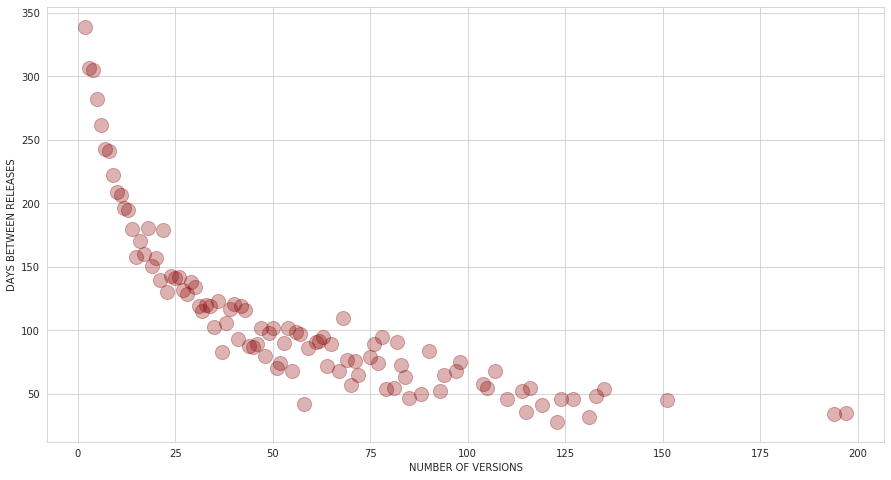

In [12]:
#plt.figure(figsize=(15,8))
#plt.plot(meanReleases)
#plt.xlabel('NUMBER OF VERSIONS')
#plt.ylabel('DAYS BETWEEN RELEASES')

plt.figure(figsize=(15, 8))
ax = sns.regplot(x=meanReleases['NumberOfVersions'], y=meanReleases['DaysBetweenReleases'], fit_reg=False, scatter_kws={"color":"darkred","alpha":0.3,"s":200})
ax.set(xlabel='NUMBER OF VERSIONS', ylabel='DAYS BETWEEN RELEASES')
plt.show()

De acuerdo con esta ley, el software en evolución tiene que adaptarse al entorno cambiante, es decir, el software tiene que cambiar continuamente para poder utilizarlo durante un período más largo. Para este caso particular, los paquetes pueden cambiar en respuesta a la actividad de corrección de errores o en respuesta a cambios en los paquetes de los que dependen. En ilustración anterior se observa la evolución de los días transcurridos entre lanzamientos de nuevas versiones (DBR) para las versiones que han lanzado los paquetes en el tiempo. Se observa que el número de días necesarios para publicar una nueva versión disminuye para los paquetes que tienen muchos lanzamientos de nuevas versiones y aumenta más de 100 días para aquellos que tienen menos de 20 lanzamientos. Una explicación de esta demostración es que los paquetes que publican lanzamientos con menos frecuencia requieren un mayor esfuerzo para adaptarse a nuevas necesidades, mientras que los paquetes que publican lanzamientos con más frecuencia (en constante actualización) requieren un menor esfuerzo.

DBR cuantifica la frecuencia con la que se publican nuevos lanzamientos. Un aumento de DBR significa que la tasa de publicación de nuevas versiones del paquete disminuye, lo que a su vez puede interpretarse como un debilitamiento de la validez de la ley. Y una disminución de DBR significa que la tasa de publicación de nuevas versiones del paquete aumenta, lo que puede interpretarse como un fortalecimiento de la ley.

## Proporción de autores que realizan lanzamientos de nuevas versiones en determinados meses

Limpieza de columna *Author*

In [13]:
# Transforma columna a una lista
df[['Author']] = df[['Author']].applymap(lambda x: [x] if not isinstance(x, list) else x)

# Elimina los valores [nan]
df[['Author']] = df[['Author']].applymap(lambda x: [] if str(x) == "[nan]" else x)

dfl = df[['Package','Author']]

In [14]:
for index, row in dfl.iterrows():
    authors = row['Author'] # Es una lista de autores
    if isinstance(authors, list):
        names = []
        for value in authors:
            # Expresiones regulares utilizadas para obtener el nombre del autor más limpio
            value_T = re.sub(r'\(.*?\)\)\)', '', value)
            value_T0 = re.sub(r'\(.*?\)\)', '', value_T)
            value_T1 = re.sub(r'\([^()]*\)', '', value_T0)
            value_T2 = re.sub(r'\(.*?\)', '', value_T1)
            value_T3 = re.split('(?!<(?:\<|\"|\[|\()[^)\]\"\>]+)[,|;](?![^(\[\"\<]+(?:\>|\)|\]|\>))|(?:\w+){0}\s(and|&)\s+(?:\w+){0}', value_T2)
            
            names.append(value_T3)

        flatten_names = list(itertools.chain.from_iterable(names)) # Concatena lista de lista en una única lista
        names_authors = [fl.strip().replace("'",'').replace('"','')\
                                   .replace('&','').replace(':','')\
                                   .replace('\n','') for fl in flatten_names if fl] # Elimina elementos en blanco en la lista

    dfl.at[index, 'Author'] = names_authors

In [15]:
dfl[['Package','Author']].head()

,Package,Author
0,A3,[Scott Fortmann-Roe]
1,A3,[Scott Fortmann-Roe]
2,A3,[Scott Fortmann-Roe]
3,aaSEA,[Raja Sekhara Reddy D.M]
4,abbyyR,"[Gaurav Sood [aut, cre]]"


In [16]:
def split_dataframe_list(df, column):
    ''' 
    Acepta una columna y divide las variables de la lista en varias filas.
    df: dataframe para dividir
    column: la columna que contiene los valores a dividir
    '''
    row_accumulator = []
    
    def split_list_to_rows(row):
        split_row = row[column]
        if isinstance(split_row, list):
            for s in split_row:
                new_row = row.to_dict()
                new_row[column] = s
                row_accumulator.append(new_row)
            if split_row == []:
                new_row = row.to_dict()
                new_row[column] = None
                row_accumulator.append(new_row)
        else:
            new_row = row.to_dict()
            new_row[column] = split_row
            row_accumulator.append(new_row)
            
    df.apply(split_list_to_rows, axis=1)
    new_df = pd.DataFrame(row_accumulator)
    
    return new_df

dfa = split_dataframe_list(dfl[['Package','Author']], 'Author').copy()
dfa.shape

(263478, 2)

In [17]:
regex_ex = r'(\[\w+(?:\,[\s|\w]+)*])' # Extrae la cadena dentro de los caracteres []
dfa['IsAuthor'] = dfa['Author'].str.extract(regex_ex, expand=True)

regex_0 = [r'(^and[^\w])|(with(\s|)(contribution(s|)|)(\s|).*(from|of|by|to)[\w|\s|]{0})', # Elimina cadenas de texto
           r'((version|updates|2|Originally|for).*(Consortium|for|from|of|by|to|later)[\w|\s|]{0})', # Elimina cadenas de texto
           r'\([^)]*\)',  # Elimina cadenas dentro de ()
           r'(\<|\>)(.+?)(\<|\>)', # Elimina cadenas dentro de < >
           r'(\'|\")' # Elimina comillas simples y comillas dobles
          ]

for reg in regex_0:
    dfa['Author'] = dfa['Author'].str.replace(reg, '')
    
dfa['Author'] = dfa['Author'].str.strip()

# Casos especiales
dfa.loc[lambda df: (df['Author'] == 'Mary E. Hunsicker') & (df['Package'] == 'bayesdfa'), 'IsAuthor'] = '[ctb]'
dfa.loc[lambda df: (df['Author'] == 'Alessandra R. Brazzale') & (df['Package'] == 'CPsurv'), 'IsAuthor'] = '[aut]'
dfa.loc[lambda df: (df['Author'] == 'Stephen L. Campbell') & (df['Package'] == 'n1qn1'), 'IsAuthor'] = '[ctb]'
dfa.loc[lambda df: (df['Author'] == 'Radoslaw Michalski') |\
                    (df['Author'] == 'Allison Davis') |\
                    (df['Author'] == 'C.E. Priebe') &\
                    (df['Package'] == 'networkDynamicData'), 'IsAuthor'] = '[aut]'
dfa.loc[lambda df: (df['Author'] == 'Kanit Wongsuphasawat') & (df['Package'] == 'vegalite'), 'IsAuthor'] = '[aut]'
dfa.loc[lambda df: (df['Author'] == 'Alberto Rodriguez-Casal') & (df['Package'] == 'alphahull'), 'IsAuthor'] = '[aut]'

dfla = dfa[~dfa['Author'].isin(['.','','&','and','Inc.',')','...'])].copy()

# Columa IsAuthor
dfla['IsAuthor'] = dfla['IsAuthor'].str.replace(r'\[|\]', '') # Elimina los [] de la columna IsAuthor
dfla['IsAuthor'] = dfla['IsAuthor'].str.split(',') # Transforma la columna en una lista
dfla['IsAuthor'].fillna(0, inplace=True) # Remplaza los valores NaN en cero
dfla.shape

(247063, 3)

In [18]:
dflan = dfla.loc[dfla.astype(str).drop_duplicates().index]
dflan.shape

(45763, 3)

In [19]:
DBR_ByAuthor = pd.merge(v_releases, dflan[['Package','Author']], how='left')
DBR_ByAuthor.head()

,Package,DatePublication,DatePublication_Shift,DaysBetweenReleases,NumberOfVersions,Author
0,zyp,2019-01-25,2013-09-19,1954.0,4.0,David Bronaugh
1,zyp,2019-01-25,2013-09-19,1954.0,4.0,Arelia Werner
2,zyp,2013-09-19,2013-08-23,27.0,4.0,David Bronaugh
3,zyp,2013-09-19,2013-08-23,27.0,4.0,Arelia Werner
4,zyp,2013-08-23,2012-10-29,298.0,4.0,David Bronaugh


In [20]:
# Promedio de días entre lanzamientos de nuevas versiones de todos los paquetes de un autor

G_DBR_ByAuthor = DBR_ByAuthor[(DBR_ByAuthor['DaysBetweenReleases'] > 0) & (DBR_ByAuthor['NumberOfVersions'] >= 5)]\
                        .groupby(['Author'])[['DaysBetweenReleases']].agg('mean')
G_DBR_ByAuthor.sort_values('DaysBetweenReleases', ascending=False, inplace=True)
G_DBR_ByAuthor.head()

,DaysBetweenReleases
Author,
"T.R. Ten Have [ctb, cph]",1847.0
"Iain MacDonald [ctb, cph]",1847.0
"Burton Garbow [ctb, cph]",1847.0
"Euginia Zharichenko [ctb, cph]",1847.0
"Richard Cook [ctb, cph]",1847.0


In [21]:
bins = [0, 31, 91, 181, 273, 366, 731, 1825, 2000]
labels = ['1 M','3 M','6 M','9 M','12 M','2 Y','5 Y', 'MORE THAN 5 YEARS']
G_DBR_ByAuthor['G_dbr'] = pd.cut(G_DBR_ByAuthor['DaysBetweenReleases'], bins=bins, labels=labels)
G_DBR_ByAuthor.reset_index(inplace=True)

# Calculando proporción de autores
proportionAuthors = G_DBR_ByAuthor.groupby('G_dbr')[['Author']].count()
proportionAuthors['ProportionOfAuthors'] = proportionAuthors.apply(lambda x:100 * x / float(x.sum()))
proportionAuthors = proportionAuthors.round({'ProportionOfAuthors': 3}).reset_index()
proportionAuthors.reset_index(inplace=True)
proportionAuthors.head()

,index,G_dbr,Author,ProportionOfAuthors
0,0,1 M,121,0.667
1,1,3 M,4194,23.116
2,2,6 M,6646,36.631
3,3,9 M,3499,19.286
4,4,12 M,1966,10.836


In [22]:
x_year = proportionAuthors['G_dbr'].tolist()
y_proportionAuthors = proportionAuthors['ProportionOfAuthors'].tolist()

c = (
    Line()
    .add_xaxis(list(map(str,x_year)))
    .add_yaxis("PROPORTION OF AUTHORS", y_proportionAuthors)
    .extend_axis(
        yaxis=opts.AxisOpts(
            name="PROPORTION OF AUTHORS",
            position="left",
            name_location="center",
            name_rotate=90,
            name_gap=50
        ),
        xaxis=opts.AxisOpts(
            position="bottom",
            name_location="center",
            name_gap=30
        )
    )
)
c.render_notebook()

<a id='section3.1.2'></a>
## Evolución del número de actualizaciones de versiones de paquetes por mes

El término actualización, se interpreta como el lanzamiento de una nueva versión de un paquete ya existente, por lo que para este caso se omiten los paquetes que han lanzado una única versión a lo largo del tiempo, y además no se consideram la primera versión del paquete ya que representa primera *versión inicial* del paquete.

In [23]:
# Obtenemos el número de versiones global de los paquetes a lo largo del tiempo
u_versions = df[['Package','DatePublication','Year/Publication','Month/Publication', 'Year_Month/Publication']].copy()
versionsByPackages = u_versions.groupby('Package')[['Package']].count()
versionsByPackages = versionsByPackages.rename(columns={'Package': 'NumberOfVersions'})
versionsByPackages.reset_index(inplace=True)
versionsByPackages.head()

,Package,NumberOfVersions
0,A3,3
1,ABC.RAP,1
2,ABCanalysis,7
3,ABCoptim,4
4,ABCp2,3


In [24]:
# Filtra los paquetes que tienen más de una versión
filter_packages = versionsByPackages[versionsByPackages['NumberOfVersions'] != 1]
df_updates = pd.merge(filter_packages, u_versions, how='left', on=['Package'])

# Para eliminar la primera versión que se lanzó del paquete y crear un nuevo df de los paquetes nuevos 
# lanzados por mes
df_updates['DatePublication_Shift'] = df_updates.groupby('Package')['DatePublication'].shift(1)

# Nuevas versiones lanzadas por mes
### Paquetes que tienen una versión
pkg_unique_version = versionsByPackages[versionsByPackages['NumberOfVersions'] == 1]

### Obtiene la primera versión del paquete
firsts_versions = df_updates[df_updates['DatePublication_Shift'].isnull()]
new_versions = pkg_unique_version.append(firsts_versions, ignore_index = True, sort=False)

# Agrupa por año/mes y cuenta el número de nuevas versiones
new_versionsByMonth = new_versions.groupby('Year_Month/Publication')[['Package']].count()
df_updates.dropna(inplace=True) # Elimina la primera versión del paquete
df_updates.head()

,Package,NumberOfVersions,DatePublication,Year/Publication,Month/Publication,Year_Month/Publication,DatePublication_Shift
1,A3,3,2013-03-26,2013,3,2013-03,2013-02-07
2,A3,3,2015-08-16,2015,8,2015-08,2013-03-26
4,ABCanalysis,7,2015-04-20,2015,4,2015-04,2015-02-13
5,ABCanalysis,7,2015-06-15,2015,6,2015-06,2015-04-20
6,ABCanalysis,7,2015-09-28,2015,9,2015-09,2015-06-15


En el *df* anterior, por ejemplo, para el paquete "A3" hay 3 versiones que se han lanzado a lo largo del tiempo, pero eliminamos la primera versión lanzada y las siguientes las tomaremos como actualizaciones de versión del paquete

In [25]:
# Obtiene el número de actualizaciones de versiones de los paquetes por mes
updatesByMonth = df_updates.groupby(['Year_Month/Publication'])[['Package']].count()
updatesByMonth = updatesByMonth.rename(columns={'Package': 'NumberOfVersionUpdates'}) 
updatesByMonth.reset_index(inplace=True)
updatesByMonth.head()

,Year_Month/Publication,NumberOfVersionUpdates
0,1999-07,8
1,1999-08,6
2,1999-09,1
3,1999-10,1
4,1999-11,7


In [26]:
x_Month = updatesByMonth['Year_Month/Publication'].tolist()
y_NumberOfUpdates = updatesByMonth['NumberOfVersionUpdates'].tolist()
y_NewPackages = new_versionsByMonth['Package'].tolist()

c = (
    Line()
    .add_xaxis(x_Month)
    .add_yaxis("NUMBER OF VERSION UPDATES", y_NumberOfUpdates,
               label_opts=opts.LabelOpts(is_show=False))
    .add_yaxis("NEW RELEASES", y_NewPackages,
               label_opts=opts.LabelOpts(is_show=False))
    .extend_axis(
        yaxis=opts.AxisOpts(
            name="NUMBER OF VERSION UPDATES",
            position="left",
            name_location="center",
            name_rotate=90,
            name_gap=50
        ),
        xaxis=opts.AxisOpts(
            name="YEAR / MONTH",
            position="bottom",
            name_location="center",
            name_gap=30
        )
    )
)
c.render_notebook()

La ilustración anterior también proporciona evidencia de la ley de cambio continuo. Aquí se ha medido el cambio contando el número mensual de actualizaciones de versiones de los paquetes. Se observa que el número de actualizaciones de versiones tiende a aumentar con el tiempo, y número de lanzamientos de nuevas versiones por mes tiende a ser estable y creciendo.

<a id='section3.1.3'></a>
## Proporción de paquetes que tienen un número determinado de actualizaciones

In [27]:
updatesByYear = df_updates.groupby(['Year/Publication','Package'])[['Package']].count()
updatesByYear = updatesByYear.rename(columns={'Package': 'NumberOfVersionUpdates'})
updatesByYear.reset_index(inplace=True)
updatesByYear.head()

,Year/Publication,Package,NumberOfVersionUpdates
0,1999,KernSmooth,1
1,1999,akima,1
2,1999,boot,1
3,1999,chron,1
4,1999,cluster,2


In [28]:
bins = [0, 1, 5, 35]
labels = ['1','2 - 5','> 6']
updatesByYear['Group_Updates'] = pd.cut(updatesByYear['NumberOfVersionUpdates'], bins=bins, labels=labels)
updatesByYear.head()

,Year/Publication,Package,NumberOfVersionUpdates,Group_Updates
0,1999,KernSmooth,1,1
1,1999,akima,1,1
2,1999,boot,1,1
3,1999,chron,1,1
4,1999,cluster,2,2 - 5


In [29]:
proportionOfUpdates = updatesByYear.groupby(['Year/Publication','Group_Updates']).agg({'NumberOfVersionUpdates': 'sum'})
proportionOfUpdates['ProportionOfPackages'] = proportionOfUpdates.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
proportionOfUpdates.reset_index(inplace=True)
proportionOfUpdates.head()

,Year/Publication,Group_Updates,NumberOfVersionUpdates,ProportionOfPackages
0,1999,1,16.0,50.000000
1,1999,2 - 5,16.0,50.000000
2,1999,> 6,NaN,NaN
3,2000,1,29.0,26.851852
4,2000,2 - 5,40.0,37.037037


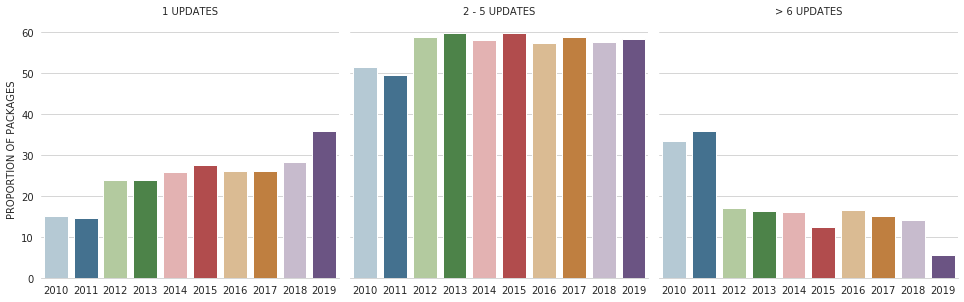

In [30]:
ax = sns.catplot(x='Year/Publication', y='ProportionOfPackages', col='Group_Updates', 
                 data=proportionOfUpdates.loc[proportionOfUpdates['Year/Publication'] >= 2010], 
                 saturation=.5, kind='bar', ci=None, height=4.5, aspect=1, palette='Paired')
ax.set_axis_labels('', 'PROPORTION OF PACKAGES')
ax.set_titles('{col_name} UPDATES')
ax.despine(left=True)

La ilustración muestra la proporción de paquetes que tienen un número determinado de actualizaciones, para ello creamos tres rangos: 1, 2 a 5, o más de 6 actualizaciones de la versión del paquete. Se puede observar que el número de actualizaciones no está distribuido uniformemente entre los paquetes: cerca de un tercio de todos los paquetes reciben 6 o más actualizaciones, y cerca de un tercio de todos los paquetes reciben un única actualización. La mayoría de los paquetes ha recibido entre 2 y 6 actualizaciones a lo largo del tiempo

<a id='section3.1.4'></a>
## Proporción de actualizaciones en 2018 por edad del paquete (en meses)

In [31]:
# Copiamos el df original y eliminamos las filas que tienen valores NaN en la fecha de publicación del paquete
df_updateAge = df.dropna(subset=['DatePublication','Version']).copy()
df_updateAge.shape

(87893, 48)

In [32]:
# Se establece Package y Version como índices y ordenamos
df_age = df_updateAge.set_index(['Package', 'Version'])
df_age.sort_values("DatePublication", ascending=True, inplace=True)
df_age.head(2)

,,Type,Title,Date,Author,Maintainer,Description,License,Depends,Suggests,Packaged,...,Priority,NumberOfImports,NumberOfDepends,NumberOfSuggests,NumberOfLinkingTo,DatePublication,Year/Publication,Month/Publication,Day/Publication,Year_Month/Publication
Package,Version,,,,,,,,,,,,,,,,,,,,,
oz,1.0-3,NaN,NaN,NaN,[S original by Bill Venables <Bill.Venables@ad...,NaN,Functions for plotting Australia's coastline a...,GPL,[],[],NaN,...,NaN,0,0,0,0,1998-02-25,1998,2,25,1998-02
mda,0.1-1,NaN,NaN,NaN,[S original by Hastie & Tibshirani.<U+000a>R p...,NaN,"Mixture and flexible discriminat analysis, mul...",???,[],[],NaN,...,NaN,0,0,0,0,1998-04-17,1998,4,17,1998-04


In [33]:
def first_and_last_package(df):
    return df.iloc[[0, -1]]

# Para obtener la fecha de la primera y última versión del paquete
df_calculateAge = df_age[['Year_Month/Publication']].groupby(level=0, group_keys=False).apply(first_and_last_package)
df_calculateAge['Year_Month/Publication'] = pd.to_datetime(df_calculateAge['Year_Month/Publication']).dt.to_period("M")
df_calculateAge.reset_index(inplace=True)
df_calculateAge.head()

,Package,Version,Year_Month/Publication
0,A3,0.9.1,2013-02
1,A3,1.0.0,2015-08
2,ABC.RAP,0.9.0,2016-10
3,ABC.RAP,0.9.0,2016-10
4,ABCanalysis,1.0,2015-02


In [34]:
dates = { ('DateFirstPackage', 'min'), ('DateLastPackage','max') }

# Calculamos la edad del paquete
ageOfPackage = pd.pivot_table(df_calculateAge, values=['Year_Month/Publication'], index=['Package'], aggfunc=['min', 'max'])
ageOfPackage.columns = list(map('_'.join, ageOfPackage.columns.values))
ageOfPackage.reset_index(inplace=True)
ageOfPackage['AgeInMonths'] = (ageOfPackage['max_Year_Month/Publication'].dt.year - ageOfPackage['min_Year_Month/Publication'].dt.year) * 12 +\
                              (ageOfPackage['max_Year_Month/Publication'].dt.month - ageOfPackage['min_Year_Month/Publication'].dt.month)
ageOfPackage.head()

,Package,min_Year_Month/Publication,max_Year_Month/Publication,AgeInMonths
0,A3,2013-02,2015-08,30
1,ABC.RAP,2016-10,2016-10,0
2,ABCanalysis,2015-02,2017-03,25
3,ABCoptim,2013-10,2017-11,49
4,ABCp2,2013-04,2016-02,34


In [35]:
# Combina el df que contiene las actualizaciones de los paquetes (no incluye primera versión ..)
# y tampoco aquellos que solo tiene un lanzamiento) con el df en el que hemos calculado la edad en
# meses de cada paquete
packages_updates = pd.merge(df_updates, ageOfPackage, how='left', on=['Package'])

# Filtra paquetes que fueron actualizados en 2018
updateByAge_2018 = packages_updates[packages_updates['Year/Publication'] == 2018]

# Agrupa por la edad en meses de paquete y cuenta el número de paquetes que se actualizaron
groupByAge = updateByAge_2018.groupby('AgeInMonths')[['Package']].count().reset_index()
groupByAge = groupByAge.rename(columns={'Package': 'NumberOfUpdates'}) 

bins = [-1, 0, 3, 6, 9, 12, 24, 48, 96, 192]
labels = ['< 1','1 - 3','4 - 6','7 - 9','10 - 12','13 - 24','25 - 48','49 - 96','> 96']

# Categoriza en varios grupos de meses para las edades del paquete
groupByAge['Group_Months'] = pd.cut(groupByAge['AgeInMonths'], bins=bins, labels=labels)
groupByAge['ProportionOfUpdates'] = groupByAge['NumberOfUpdates'] / groupByAge['NumberOfUpdates'].sum() * 100
groupByAge.head()

,AgeInMonths,NumberOfUpdates,Group_Months,ProportionOfUpdates
0,0,56,< 1,0.556881
1,1,91,1 - 3,0.904932
2,2,99,1 - 3,0.984487
3,3,89,1 - 3,0.885044
4,4,111,4 - 6,1.103819


In [36]:
# Calcula la proporción del actualizaciones para el grupo de edades
proportionOfUpdatesAge = groupByAge.groupby(["Group_Months"]).agg({'NumberOfUpdates': 'sum', 'ProportionOfUpdates': 'sum'})
proportionOfUpdatesAge.reset_index(inplace=True)
proportionOfUpdatesAge

,Group_Months,NumberOfUpdates,ProportionOfUpdates
0,< 1,56,0.556881
1,1 - 3,279,2.774463
2,4 - 6,321,3.192124
3,7 - 9,400,3.977725
4,10 - 12,588,5.847255
5,13 - 24,2592,25.775656
6,25 - 48,2707,26.919252
7,49 - 96,1887,18.764916
8,> 96,1073,10.670247


Text(0, 0.5, 'PROPORTION OF UPDATES')

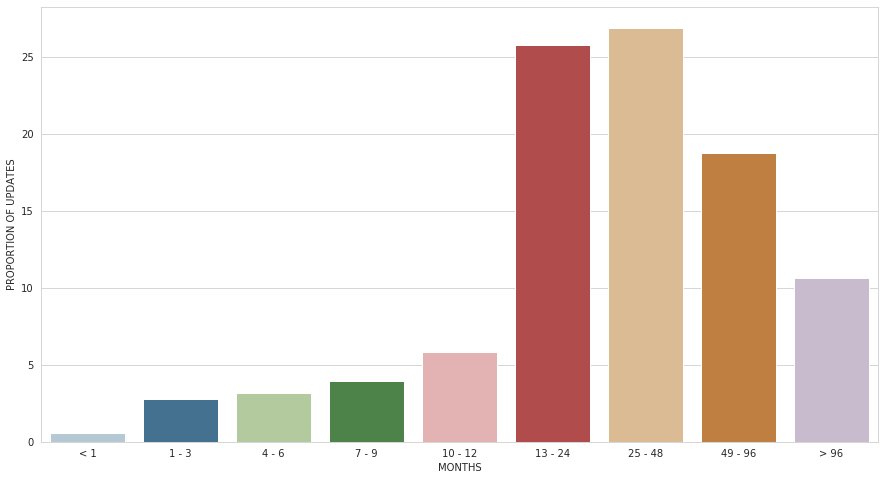

In [37]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x='Group_Months', y='ProportionOfUpdates', data=proportionOfUpdatesAge, 
                 palette='Paired', saturation=.5)
plt.xlabel('MONTHS')
plt.ylabel('PROPORTION OF UPDATES')

La ilustración anterior presenta la proporción de actualizaciones de versiones de los paquetes en 2018 en términos de la antigüedad de los paquetes. Los resultados reflejan que la mayoría de las actualizaciones de versiones se realizan a paquetes que tienen más de 1 año de antigüedad. Este comportamiento podría atribuirse a que es un ecosistema muy antiguo, y que tiene muchos paquetes potentes que son antiguos y aún se siguen manteniendo.

<a id='section3.2'></a>
## 3.2 Crecimiento Continuo

De acuerdo con esta ley, la funcionalidad proporcionada por el software debe crecer continuamente para proporcionar satisfacción al usuario final durante su vida útil. El término "crecimiento" puede interpretarse obviamente como una referencia al tamaño del producto de software. Por lo tanto, el crecimiento continuo puede validarse mediante el cálculo de métricas de tamaño de software como el número de módulos, número de métodos o líneas de código a lo largo del tiempo. Este es el enfoque utilizado por Lehman y otros.
En este caso, para evidenciar la ley de crecimiento continuo a nivel de ecosistema CRAN se ha definido como métricas de evolución el número de paquetes, número de dependencias y número de versiones del paquete. Observando estas métricas podríamos determinar si el ecosistema ha crecido en tamaño.

<a id='section3.2.1'></a>
## Evolución del número de paquetes

Agrupa por año y cuenta el número de paquetes

In [38]:
numbers_package = df.groupby('Year/Publication')[['Package']].count()
numbers_package = numbers_package.rename(columns={'Package': 'NumberOfPackages'})
numbers_package = numbers_package.sort_values('Year/Publication', ascending=True)
numbers_package.reset_index(inplace=True)
numbers_package

,Year/Publication,NumberOfPackages
0,1997,1
1,1998,7
2,1999,70
3,2000,133
4,2001,318
5,2002,448
6,2003,601
7,2004,885
8,2005,1223
9,2006,1698


In [39]:
x_year = numbers_package[numbers_package['Year/Publication'] != 2019]['Year/Publication'].tolist()
y_packages = numbers_package['NumberOfPackages'].tolist()

c = (
    Line()
    .add_xaxis(list(map(str,x_year)))
    .add_yaxis("NUMBER OF R PACKAGE ON CRAN", y_packages, label_opts=opts.LabelOpts(is_show=False))
    .extend_axis(
        yaxis=opts.AxisOpts(
            name="NUMBER OF PACKAGES",
            position="left",
            name_location="center",
            name_rotate=90,
            name_gap=50
        ),
        xaxis=opts.AxisOpts(
            name="YEAR",
            position="bottom",
            name_location="center",
            name_gap=30
        )
    )
)
c.render_notebook()

En la siguiente figura se presenta se presenta la evolución del número de paquetes, utilizando una escala logarítmica para el eje *y*.

In [40]:
numbers_pkgByMonth = df.groupby('Year_Month/Publication')[['Package']].count()
numbers_pkgByMonth = numbers_pkgByMonth.rename(columns={'Package': 'NumberOfPackages'})
numbers_pkgByMonth['CumulativeSum'] = numbers_pkgByMonth['NumberOfPackages'].cumsum()
numbers_pkgByMonth.drop('NumberOfPackages', axis=1, inplace=True)
numbers_pkgByMonth = numbers_pkgByMonth.sort_values('Year_Month/Publication', ascending=True)
numbers_pkgByMonth = numbers_pkgByMonth[numbers_pkgByMonth.index != "NaT"]
numbers_pkgByMonth.head()

,CumulativeSum
Year_Month/Publication,
1997-12,1
1998-02,2
1998-04,3
1998-08,5
1998-11,7


Text(0, 0.5, 'CUMULATIVE SUM OF NUMBER OF PACKAGES (LOG)')

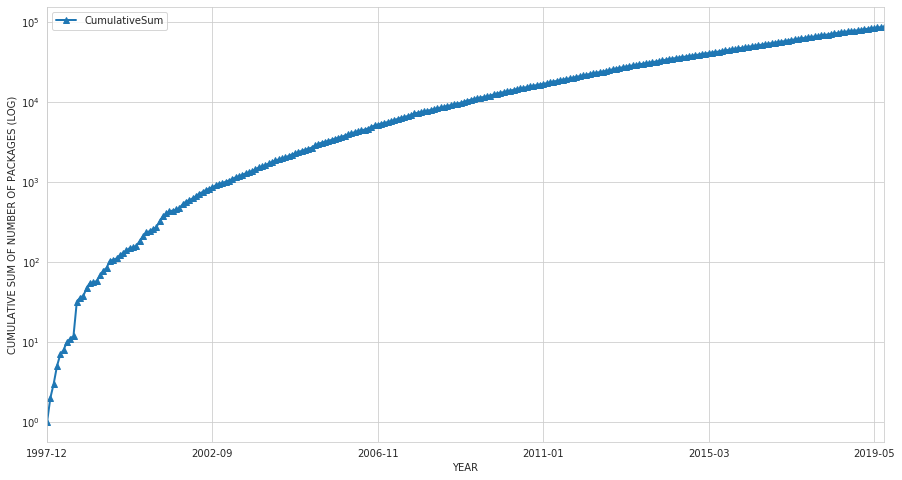

In [41]:
fig, ax = plt.subplots(figsize=(15, 8))

numbers_pkgByMonth.plot(x_compat=True, ax=ax, lw=2, marker='^')
ax.set_yscale('log')
plt.xlabel('YEAR')
plt.ylabel('CUMULATIVE SUM OF NUMBER OF PACKAGES (LOG)')

<a id='section3.2.2'></a>
## Evolución del número de dependencias (Imports, Depends, Suggests)

Se considera para cada tiempo únicamente la última versión disponible de cada paquete

In [42]:
df_law_IV = df.dropna(subset=['DatePublication']).copy()
df_law_IV.set_index(["Year/Publication", "Package"], inplace=True)
df_law_IV.sort_values('DatePublication', ascending=False, inplace=True)

In [43]:
df_law_IV.shape

(87912, 46)

In [44]:
def last_version_package_by_year(df):
    return df.iloc[[0]]

# Agrupa por año y paquete para obtener la última versión de paquete públicada en determinado año
dfl_law_IV = df_law_IV.groupby(level=[0,1], group_keys=False).apply(last_version_package_by_year)
dfl_law_IV = dfl_law_IV.reset_index()
dfl_law_IV.shape

(42125, 48)

In [45]:
numbersDEP = dfl_law_IV.groupby(['Year/Publication']).agg({'NumberOfImports': ['sum'],
                                                           'NumberOfDepends': ['sum'],
                                                           'NumberOfSuggests': ['sum'],
                                                           'NumberOfLinkingTo': ['sum']}).reset_index()
numbersDEP.columns = list(map(''.join, numbersDEP.columns.values))

In [46]:
numbersDEP

,Year/Publication,NumberOfImportssum,NumberOfDependssum,NumberOfSuggestssum,NumberOfLinkingTosum
0,1997,0,0,0,0
1,1998,0,0,0,0
2,1999,0,13,1,0
3,2000,0,37,0,0
4,2001,0,73,2,0
5,2002,0,155,2,0
6,2003,0,234,6,0
7,2004,23,347,82,0
8,2005,45,585,211,0
9,2006,93,986,381,1


Text(0.5, 0, 'YEAR')

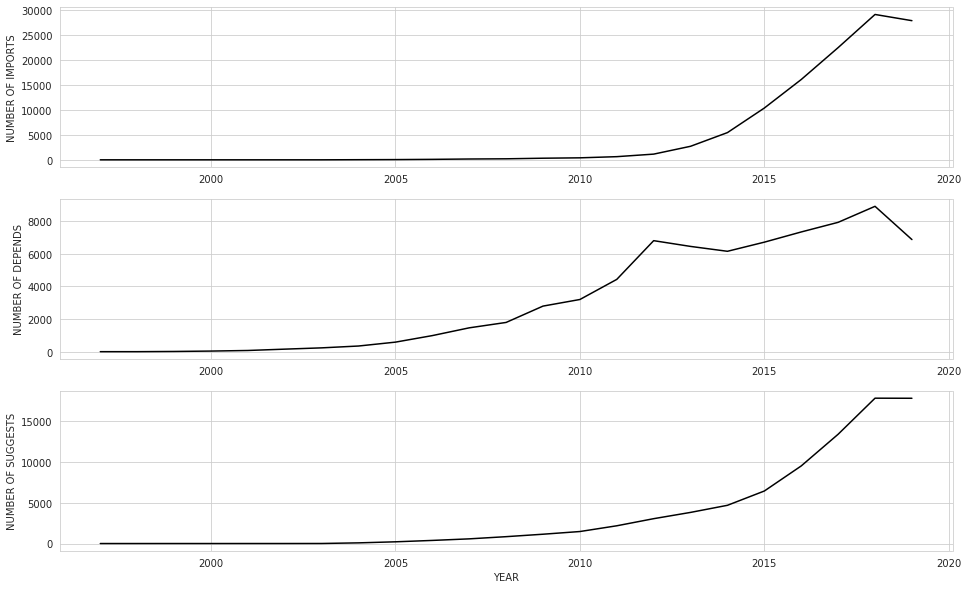

In [47]:
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

ax1.plot(numbersDEP['Year/Publication'], numbersDEP['NumberOfImportssum'], 'k')
ax1.set_ylabel('NUMBER OF IMPORTS')

ax2.plot(numbersDEP['Year/Publication'], numbersDEP['NumberOfDependssum'], 'k')
ax2.set_ylabel('NUMBER OF DEPENDS')

ax3.plot(numbersDEP['Year/Publication'], numbersDEP['NumberOfSuggestssum'], 'k')
ax3.set_ylabel('NUMBER OF SUGGESTS')
ax3.set_xlabel('YEAR')

<a id='section3.2.2.1'></a>
## Evolución de dependencias según el tiempo de vida del repositorio

In [48]:
df_TL = df[['DatePublication','Year/Publication','Package','Version_R',
                         'NumberOfImports','NumberOfDepends','NumberOfSuggests','NumberOfLinkingTo',
                         'Imports','Depends','Suggests','LinkingTo']].copy()
df_TL.head(2)

,DatePublication,Year/Publication,Package,Version_R,NumberOfImports,NumberOfDepends,NumberOfSuggests,NumberOfLinkingTo,Imports,Depends,Suggests,LinkingTo
0,2013-02-07,2013,A3,NaN,0,2,2,0,[],"['xtable', 'pbapply']","['randomForest', 'e1071']",[]
1,2013-03-26,2013,A3,>= 2.15.0,0,3,2,0,[],"['R', 'xtable', 'pbapply']","['randomForest', 'e1071']",[]


In [49]:
df_TL['5_years'] = pd.cut(df_TL['Year/Publication'], bins=[1996, 2002], labels=[5])
df_TL['10_years'] = pd.cut(df_TL['Year/Publication'], bins=[1996, 2008], labels=[10])
df_TL['15_years'] = pd.cut(df_TL['Year/Publication'], bins=[1996, 2014], labels=[15])
df_TL['21_years'] = pd.cut(df_TL['Year/Publication'], bins=[1996, 2020], labels=[21])
df_TL.reset_index(inplace=True)

[Text(0, 0.5, 'NUMBER OF DEPENDENCIES'), Text(0.5, 0, 'TIME OF LIFE')]

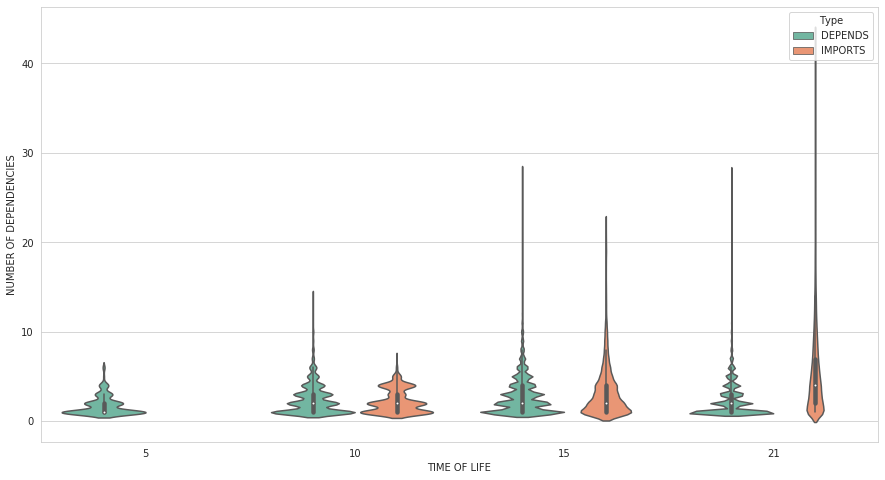

In [50]:
flatten_TL = pd.DataFrame()

for tl in ['5_years','10_years','15_years','21_years']:
    
    ##################################################################
    x = df_TL[ (df_TL['NumberOfImports'] != 0) &
                (df_TL[tl] == pd.to_numeric(tl.replace('_years','')))][['NumberOfImports',tl]]          
    x = x.rename(columns={'NumberOfImports': 'Number', tl: 'TimeOfLive'})
    x['Type'] = 'IMPORTS'

    ##################################################################
    y = df_TL[ (df_TL['NumberOfDepends'] != 0) &
                (df_TL[tl] == pd.to_numeric(tl.replace('_years','')))][['NumberOfDepends',tl]]
    y = y.rename(columns={'NumberOfDepends': 'Number', tl: 'TimeOfLive'})
    y['Type'] = 'DEPENDS'
    
    c_XY = pd.concat([x, y], ignore_index=True)
    flatten_TL = flatten_TL.append(c_XY, ignore_index=True)

plt.figure(figsize=(15,8))
ax = sns.violinplot(x="TimeOfLive", y="Number", hue="Type", data=flatten_TL, palette="Set2")
ax.set(xlabel='TIME OF LIFE', ylabel='NUMBER OF DEPENDENCIES')

[Text(0, 0.5, 'NUMBER OF DEPENDENCIES'), Text(0.5, 0, 'TIME OF LIFE')]

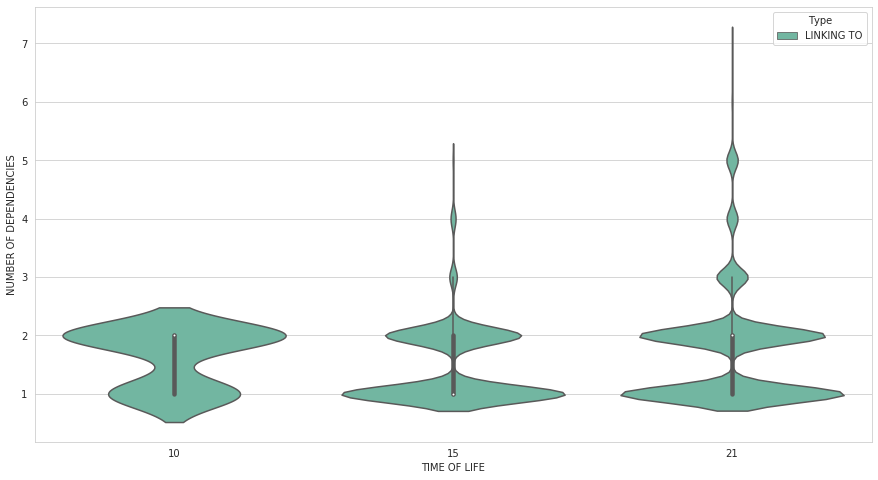

In [51]:
flatten_TL_LT = pd.DataFrame()

for tl in ['5_years','10_years','15_years','21_years']:
    
    ##################################################################
    x = df_TL[ (df_TL['NumberOfLinkingTo'] != 0) &
                (df_TL[tl] == pd.to_numeric(tl.replace('_years','')))][['NumberOfLinkingTo',tl]]
    x = x.rename(columns={'NumberOfLinkingTo': 'Number', tl: 'TimeOfLive'})
    x['Type'] = 'LINKING TO'

    c_XY = pd.concat([x], ignore_index=True)
    flatten_TL_LT = flatten_TL_LT.append(c_XY, ignore_index=True)

plt.figure(figsize=(15,8))
ax = sns.violinplot(x="TimeOfLive", y="Number", hue="Type", data=flatten_TL_LT, palette="Set2")
ax.set(xlabel='TIME OF LIFE', ylabel='NUMBER OF DEPENDENCIES')

[Text(0, 0.5, 'NUMBER OF DEPENDENCIES'), Text(0.5, 0, 'TIME OF LIFE')]

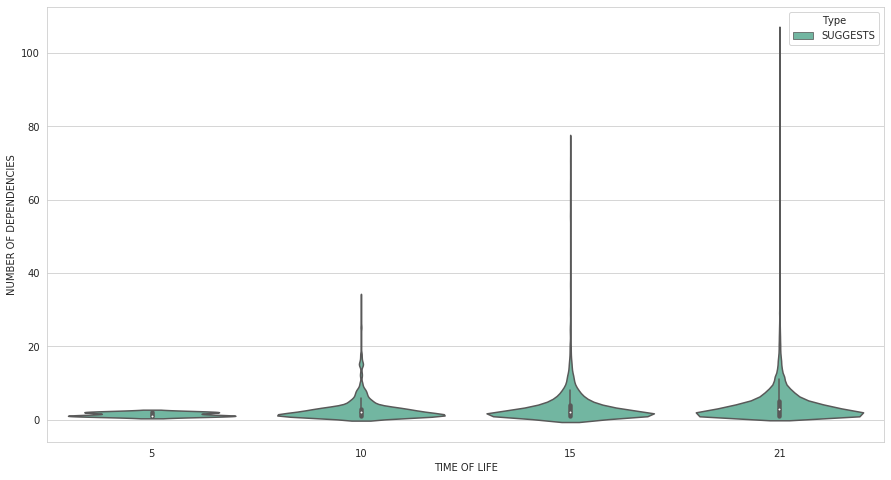

In [52]:
flatten_TL_LS = pd.DataFrame()

for tl in ['5_years','10_years','15_years','21_years']:
    
    x = df_TL[ (df_TL['NumberOfSuggests'] != 0) &
               (df_TL[tl] == pd.to_numeric(tl.replace('_years','')))][['NumberOfSuggests',tl]]
    x = x.rename(columns={'NumberOfSuggests': 'Number', tl: 'TimeOfLive'})
    x['Type'] = 'SUGGESTS'
    
    c_XY = pd.concat([x], ignore_index=True)
    flatten_TL_LS = flatten_TL_LS.append(c_XY, ignore_index=True)
    
plt.figure(figsize=(15,8))
ax = sns.violinplot(x="TimeOfLive", y="Number", hue="Type", data=flatten_TL_LS, palette="Set2")
ax.set(xlabel='TIME OF LIFE', ylabel='NUMBER OF DEPENDENCIES')

## Promedio del número de dependencias (Imports, Depends, Suggests) según el tiempo de vida del repositorio

In [53]:
TL = ['5_years','10_years','15_years','21_years']
df_TLP = pd.DataFrame(columns=['NumberOfImports_sum','NumberOfDepends_sum','NumberOfSuggests_sum',
                            'NumberOfImports_mean','NumberOfDepends_mean','NumberOfSuggests_mean'])

for l in TL:
    result = df_TL.groupby([l]).agg({'NumberOfImports': ['sum','mean'],
                                        'NumberOfDepends': ['sum','mean'],
                                        'NumberOfSuggests': ['sum','mean'],
                                        'NumberOfLinkingTo': ['sum','mean']})
    result.columns = list(map('_'.join, result.columns.values))
    df_TLP = pd.concat([df_TLP, result], axis=0, sort=False).copy()

df_TLU = df_TLP.stack().to_frame()
df_TLU.reset_index(inplace=True)
df_TLU = df_TLU.rename(columns={'level_0': 'TimeOfLife', 'level_1': 'TypeDependency', 0: 'Value'})
df_TLU[['TypeDependency','Calculate']] = df_TLU['TypeDependency'].str.split('_', expand=True) 
df_TLU.shape

(32, 4)

In [54]:
df_TLU.head()

,TimeOfLife,TypeDependency,Value,Calculate
0,5,NumberOfImports,0,sum
1,5,NumberOfDepends,993,sum
2,5,NumberOfSuggests,13,sum
3,5,NumberOfImports,0,mean
4,5,NumberOfDepends,1.01638,mean


In [55]:
g_TLU = df_TLU.set_index(['TimeOfLife', 'Calculate', 'TypeDependency']).unstack('Calculate')
g_TLU.reset_index(inplace=True)
g_TLU.columns = list(map('_'.join, g_TLU.columns.values))
g_TLU.fillna(0, inplace=True)
g_TLU.sort_values('TimeOfLife_', ascending=True, inplace=True)
g_TLU = g_TLU.round({'Value_mean': 2})
g_TLU.head()

,TimeOfLife_,TypeDependency_,Value_mean,Value_sum
0,5,NumberOfDepends,1.02,993.0
1,5,NumberOfImports,0.00,0.0
2,5,NumberOfLinkingTo,0.00,0.0
3,5,NumberOfSuggests,0.01,13.0
4,10,NumberOfDepends,2.00,19505.0


In [56]:
x_life = np.unique(g_TLU['TimeOfLife_']).tolist()
x_mean_IMP = g_TLU[g_TLU['TypeDependency_'] == 'NumberOfImports']['Value_mean'].tolist()
x_mean_DEP = g_TLU[g_TLU['TypeDependency_'] == 'NumberOfDepends']['Value_mean'].tolist()
x_mean_SUG = g_TLU[g_TLU['TypeDependency_'] == 'NumberOfSuggests']['Value_mean'].tolist()
x_mean_LINK = g_TLU[g_TLU['TypeDependency_'] == 'NumberOfLinkingTo']['Value_mean'].tolist()

c = (
        Line()
        .add_xaxis(list(map(str,x_life)))
        .add_yaxis('IMPORTS', x_mean_IMP)
        .add_yaxis('DEPENDS', x_mean_DEP)
        .add_yaxis('SUGGESTS', x_mean_SUG)
        .add_yaxis('LINKING TO', x_mean_LINK)
)
c.render_notebook()

In [57]:
x_life = np.unique(g_TLU['TimeOfLife_']).tolist()

x_sum_IMP = g_TLU[g_TLU['TypeDependency_'] == 'NumberOfImports']['Value_sum'].tolist()
x_sum_DEP = g_TLU[g_TLU['TypeDependency_'] == 'NumberOfDepends']['Value_sum'].tolist()
x_sum_SUG = g_TLU[g_TLU['TypeDependency_'] == 'NumberOfSuggests']['Value_sum'].tolist()
x_sum_LINK = g_TLU[g_TLU['TypeDependency_'] == 'NumberOfLinkingTo']['Value_sum'].tolist()

c = (
        Bar()
        .add_xaxis(x_life)
        .add_yaxis('IMPORTS', x_sum_IMP)
        .add_yaxis('DEPENDS', x_sum_DEP)
        .add_yaxis('SUGGESTS', x_sum_SUG)
        .add_yaxis('LINKING TO', x_sum_LINK)
)
c.render_notebook()

<a id='section3.2.3'></a>
## Evolución del promedio de dependencias (Imports, Depends, Suggests)

In [58]:
avg_DEP = df_law_IV.groupby(['Year/Publication']).agg({'NumberOfImports': ['mean'],
                                                        'NumberOfDepends': ['mean'],
                                                        'NumberOfSuggests': ['mean'],
                                                        'NumberOfLinkingTo': ['mean']}).reset_index()
avg_DEP.columns = list(map(''.join, avg_DEP.columns.values))

avg_DEP['NumberOfImportsmean'] = avg_DEP['NumberOfImportsmean'].map('{:,.2f}'.format)
avg_DEP['NumberOfDependsmean'] = avg_DEP['NumberOfDependsmean'].map('{:,.2f}'.format)
avg_DEP['NumberOfSuggestsmean'] = avg_DEP['NumberOfSuggestsmean'].map('{:,.2f}'.format)
avg_DEP['NumberOfLinkingTomean'] = avg_DEP['NumberOfLinkingTomean'].map('{:,.2f}'.format)

avg_DEP

,Year/Publication,NumberOfImportsmean,NumberOfDependsmean,NumberOfSuggestsmean,NumberOfLinkingTomean
0,1997,0.00,0.00,0.00,0.00
1,1998,0.00,0.00,0.00,0.00
2,1999,0.00,0.41,0.03,0.00
3,2000,0.00,0.72,0.00,0.00
4,2001,0.00,0.88,0.02,0.00
5,2002,0.00,1.31,0.01,0.00
6,2003,0.00,1.49,0.02,0.00
7,2004,0.15,1.49,0.31,0.00
8,2005,0.31,1.73,0.71,0.00
9,2006,0.33,2.04,0.93,0.01


In [59]:
x_year = avg_DEP['Year/Publication'].tolist()
Imports_avg = avg_DEP['NumberOfImportsmean'].tolist()
Depends_avg = avg_DEP['NumberOfDependsmean'].tolist()
Suggests_avg = avg_DEP['NumberOfSuggestsmean'].tolist()

c = (
        Line()
        .add_xaxis(list(map(str,x_year)))
        .add_yaxis(
            'AVERAGE OF PACKAGE IMPORTS',
            Imports_avg,
            #markline_opts=opts.MarkLineOpts(data=[opts.MarkLineItem(type_="average")]),
            label_opts=opts.LabelOpts(is_show=False)
        )
        .add_yaxis(
            'AVERAGE OF PACKAGE DEPENDS',
            Depends_avg,
            #markline_opts=opts.MarkLineOpts(data=[opts.MarkLineItem(type_="average")]),
            label_opts=opts.LabelOpts(is_show=False)
        )
        .add_yaxis(
            'AVERAGE OF PACKAGE SUGGEST',
            Suggests_avg,
            #markline_opts=opts.MarkLineOpts(data=[opts.MarkLineItem(type_="average")]),
            label_opts=opts.LabelOpts(is_show=False)
        )
        .extend_axis(
            yaxis=opts.AxisOpts(
                name="AVG OF PACKAGE",
                type_="log",
                is_scale=True,
                position="left",
                name_location="center",
                name_rotate=90,
                name_gap=30
            ),
            xaxis=opts.AxisOpts(
                name="YEAR",
                position="bottom",
                name_location="center",
                name_gap=30
            )
        )
)
c.render_notebook()

<a id='section3.2.4'></a>
## Evolución de paquetes por versión del lenguaje

In [60]:
df[df['Version_R']=='>=1.5.0'][['Year/Publication','Package','Version_R']].head()

,Year/Publication,Package,Version_R
35111,2002,ISwR,>=1.5.0
35112,2002,ISwR,>=1.5.0


In [61]:
df_version = df.dropna(subset=['DatePublication','Version_R']).copy()
df_version['Version_R'] = df_version['Version_R'].str.replace('\n',' ')
df_version['Version_R'] = df_version['Version_R'].str.replace('\<U\+000a\>',' ')
df_version['Version_R'] = df_version['Version_R'].str.replace('-','.')
df_version['SymbolR'] = df_version['Version_R'].str.extract('(>=|<=|<|>|\*)', expand=True)
df_version['Version_R'] = df_version['Version_R'].replace(r'(>=|<=|<|>|\*)', '', regex=True)
df_version['Version_R'] = df_version['Version_R'].str.strip()
df_version['SymbolR'] = df_version['SymbolR'].str.strip()

df_version[['Year/Publication','Package','Version_R','SymbolR']].head()

,Year/Publication,Package,Version_R,SymbolR
1,2013,A3,2.15.0,>=
2,2015,A3,2.15.0,>=
3,2019,aaSEA,3.4.0,>=
4,2015,abbyyR,3.2.0,>=
5,2015,abbyyR,3.2.0,>=


In [62]:
df_version['SymbolR'].unique()

array(['>=', '*', '<', '>', '<='], dtype=object)

In [63]:
df_version[df_version['SymbolR'].isin(['*','<','<='])].shape

(121, 49)

In [64]:
df_version = df_version[~df_version['SymbolR'].isin(['*','<','>'])]
df_version.shape

(57862, 49)

In [65]:
pkg_ByVersionR = df_version.groupby(['Year/Publication','Version_R'])[['Package']].count()
pkg_ByVersionR = pkg_ByVersionR.rename(columns={'Package': 'NumberOfPackages'})
pkg_ByVersionR = pkg_ByVersionR.sort_values('Version_R', ascending=False)
pkg_ByVersionR.reset_index(inplace=True)
pkg_ByVersionR.fillna(0, inplace=True)

pkg_ByVersionR['VersionR_AsNumber'] = pd.to_numeric(pkg_ByVersionR['Version_R'].str.split('.').str[0] + '.' + 
                                        pkg_ByVersionR['Version_R'].str.split('.').str[1].str.slice(0,1))
pkg_ByVersionR['VersionR_AsNumber'].unique()

array([3.6, 3.5, 3.4, 3.3, 3.2, 3.1, 3. , 2.9, 2.8, 2.7, 2.6, 2.5, 2.4,
       2.3, 2.2, 2.1, 2. , 1.9, 1.8, 1.7, 1.6, 1.5, 1.4, 1.3, 1.2, 1.1,
       1. , 0.9, 0.6, 0.1])

In [66]:
bins = [0, 1.9, 2.4, 2.9, 3.9]
labels = ['< 2.0.x','>= 2.0.x','>= 2.5.x','>= 3.0.0']

# Categoriza en varios grupos de meses para las edades del paquete
pkg_ByVersionR['G_Version_R'] = pd.cut(pkg_ByVersionR['VersionR_AsNumber'], bins=bins, labels=labels)
pkg_ByVersionR[['VersionR_AsNumber','G_Version_R']].sort_values('VersionR_AsNumber',ascending=True).drop_duplicates(keep='last')

,VersionR_AsNumber,G_Version_R
1128,0.1,< 2.0.x
1123,0.6,< 2.0.x
1118,0.9,< 2.0.x
1089,1.0,< 2.0.x
1067,1.1,< 2.0.x
1050,1.2,< 2.0.x
1025,1.3,< 2.0.x
1010,1.4,< 2.0.x
973,1.5,< 2.0.x
940,1.6,< 2.0.x


In [67]:
groupVersionR = pkg_ByVersionR.groupby(['Year/Publication','G_Version_R'])[['NumberOfPackages']].sum()
groupVersionR.fillna(0, inplace=True)
groupVersionR['ProportionOfPackages'] = groupVersionR.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
groupVersionR.reset_index(inplace=True)
groupVersionR.sort_values('Year/Publication', ascending=True, inplace=True)
groupVersionR.head()

,Year/Publication,G_Version_R,NumberOfPackages,ProportionOfPackages
0,2000,< 2.0.x,39.0,100.0
1,2000,>= 2.0.x,0.0,0.0
2,2000,>= 2.5.x,0.0,0.0
3,2000,>= 3.0.0,0.0,0.0
4,2001,< 2.0.x,114.0,100.0


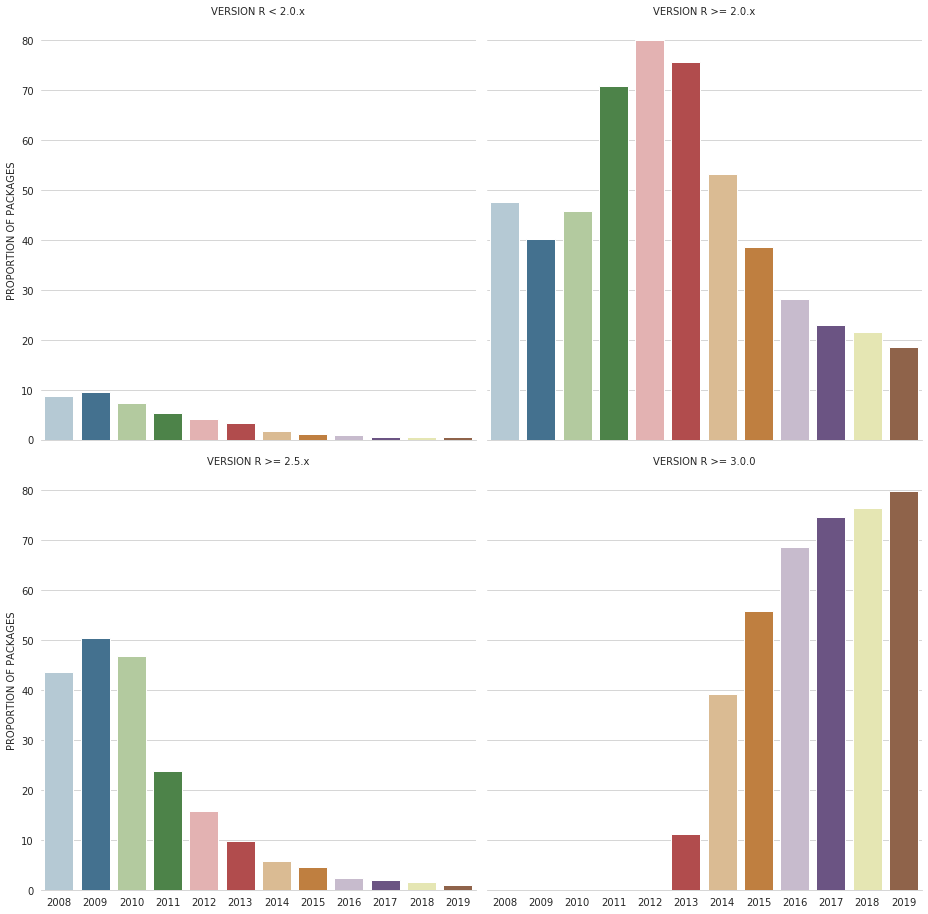

In [68]:
ax = sns.catplot(x='Year/Publication', y='ProportionOfPackages', col='G_Version_R', 
                data=groupVersionR[groupVersionR['Year/Publication'] >= 2008], 
                saturation=.5, kind='bar', ci=None, height=6.5, aspect=1, palette='Paired', col_wrap=2)
ax.set_axis_labels('', 'PROPORTION OF PACKAGES')
ax.set_titles('VERSION R {col_name}')
ax.despine(left=True)

<a id='section3.2.5'></a>
## Evolución del número de versiones por paquete

In [69]:
versions_package = df.groupby('Package')[['Package']].count()
versions_package = versions_package.rename(columns={'Package': 'NumberOfVersions'}) 
versions_package = versions_package.sort_values('NumberOfVersions', ascending=False).head(30).reset_index()
versions_package.head()

,Package,NumberOfVersions
0,Matrix,197
1,spatstat,194
2,mgcv,151
3,nlme,135
4,lattice,133


Se puede observar que los paquetes *Matrix* y *spatstat* tienen el mayor número de versiones

In [70]:
x_package = versions_package['Package'].to_list()
y_numversions = versions_package['NumberOfVersions'].to_list()

c = (
        Bar({"theme": ThemeType.WESTEROS})
        .add_xaxis(x_package)
        .add_yaxis("NUMBER OF VERSIONS", y_numversions)
        .set_global_opts(
            xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(rotate=90)),
        #    datazoom_opts=opts.DataZoomOpts(orient="horizontal"),
        )
)
c.render_notebook()

In [71]:
filter_20 = versions_package['Package'][0:10].tolist()
df_versionByPkg = df[df['Package'].isin(filter_20)].copy()
df_versionByPkg.shape

(1442, 48)

In [72]:
df_versionByPkg.dropna(subset=['DatePublication'], inplace=True)
df_versionByPkg.shape

(1442, 48)

In [73]:
groupByPkg = df_versionByPkg.groupby(['Year/Publication','Package'])[['Package']].count()
groupByPkg = groupByPkg.rename(columns={'Package': 'NumberOfVersions'})
groupByPkg.reset_index(inplace=True)
groupByPkg.head()

,Year/Publication,Package,NumberOfVersions
0,1999,nlme,2
1,2000,Matrix,7
2,2000,mgcv,4
3,2000,nlme,6
4,2001,Matrix,6


Text(0, 0.5, 'NUMBER OF VERSIONS')

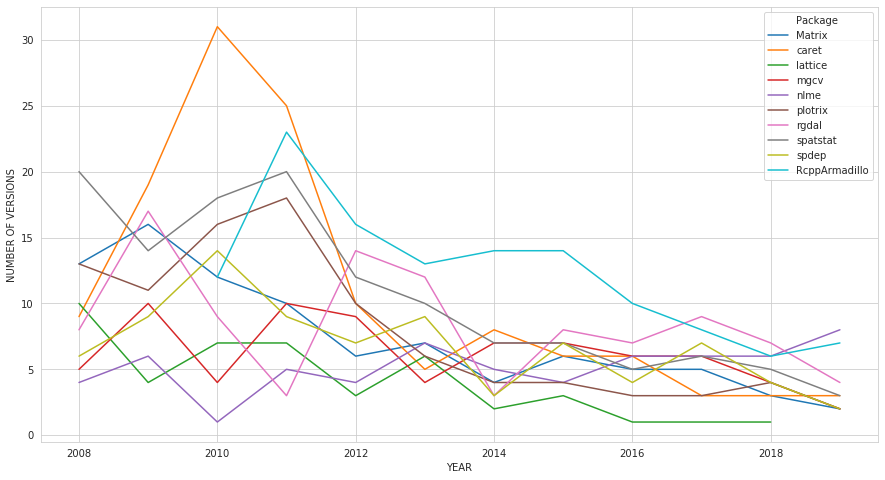

In [74]:
#sns.set_style('darkgrid', {'legend.frameon':True})
plt.figure(figsize=(15,8))
ax = sns.lineplot(x='Year/Publication', y='NumberOfVersions', hue='Package', 
                  data=groupByPkg[groupByPkg['Year/Publication'] >= 2008])
plt.xlabel("YEAR")
plt.ylabel("NUMBER OF VERSIONS")

<a id='section3.3'></a>
## 3.3 Aumento de la complejidad

La ley de complejidad creciente afirma que la complejidad de un sistema de software tiende a aumentar con el tiempo a menos que se tomen medidas proactivas para reducir o mantener la complejidad. Para evaluar la complejidad del ecosistema R hemos determinado como dimensión principal las dependencias entre los paquetes R argumentando que mientras las dependencias tienden a reducir el esfuerzo de desarrollo de paquetes individuales, aumenta la complejidad general del ecosistema a través de la necesidad de manejar estas dependencias. Esta complejidad puede causar muchos problemas de mantenimiento y fallos en el ecosistema.

In [75]:
df_GT = pd.read_csv('DATA_CRAN/CRAN_TRANSITIVE_RELATIONSHIPS_(2014-2019).csv', sep=';', low_memory=False)

In [76]:
# Ordenamos el dataframe
# MainPackage: es el paquete del cuál encontraremos la dependencia transitiva
# Package: es el paquete con el que se tiene una relación de dependecia, cuando "MainPackage" y "Package"
# son el mismo la columna "Imports" representa una dependencia directa
# Imports: representa una dependencia transitiva
# level: es el nivel de transitividad
# Relationship: representa una cadena de dependencias

df_rel = df_GT[['MainPackage','Package','Imports','level','Relationship','Year/Publication','Year_Month/Publication']].copy()
df_rel.head()

,MainPackage,Package,Imports,level,Relationship,Year/Publication,Year_Month/Publication
0,AER,AER,stats,0,AER|stats,2014.0,2014-01
1,AER,AER,Formula,0,AER|Formula,2014.0,2014-01
2,AGD,AGD,gamlss,0,AGD|gamlss,2014.0,2014-12
3,AGD,AGD,gamlss_dist,0,AGD|gamlss_dist,2014.0,2014-12
4,AICcmodavg,AICcmodavg,methods,0,AICcmodavg|methods,2014.0,2014-10


In [77]:
df_rel.shape

(1629860, 7)

In [78]:
def dependency_type(x):
    '''
    Función para categorizar la dependencia
    '''
    if x <= 0:
        return 'DIRECT DEPENDENCY'
    elif x >= 1:
        return 'TRANSITIVE DEPENDENCY'
    
df_rel['TypeDependency'] = df_rel['level'].apply(dependency_type)
df_rel.head()

,MainPackage,Package,Imports,level,Relationship,Year/Publication,Year_Month/Publication,TypeDependency
0,AER,AER,stats,0,AER|stats,2014.0,2014-01,DIRECT DEPENDENCY
1,AER,AER,Formula,0,AER|Formula,2014.0,2014-01,DIRECT DEPENDENCY
2,AGD,AGD,gamlss,0,AGD|gamlss,2014.0,2014-12,DIRECT DEPENDENCY
3,AGD,AGD,gamlss_dist,0,AGD|gamlss_dist,2014.0,2014-12,DIRECT DEPENDENCY
4,AICcmodavg,AICcmodavg,methods,0,AICcmodavg|methods,2014.0,2014-10,DIRECT DEPENDENCY


In [79]:
df_rel[df_rel['Year/Publication'].isna()]

,MainPackage,Package,Imports,level,Relationship,Year/Publication,Year_Month/Publication,TypeDependency


<a id='section3.3.1'></a>
## Distribución del número de dependencias directas y transitivas por paquete, para paquetes que tienen al menos una dependencia

Para cada paquete en CRAN calculamos el conjunto de dependencias directas y transitivas

In [80]:
depByPackages = df_rel.groupby(['Year/Publication','MainPackage','TypeDependency'])[['Imports']].count()
depByPackages = depByPackages.rename(columns={'Imports': 'NumberOfDependentPkg'})
depByPackages.reset_index(inplace=True)
depByPackages.head()

,Year/Publication,MainPackage,TypeDependency,NumberOfDependentPkg
0,2014.0,AER,DIRECT DEPENDENCY,2
1,2014.0,AGD,DIRECT DEPENDENCY,2
2,2014.0,AGD,TRANSITIVE DEPENDENCY,2
3,2014.0,AICcmodavg,DIRECT DEPENDENCY,10
4,2014.0,AICcmodavg,TRANSITIVE DEPENDENCY,27


En la siguiente ilustración observamos que el número de dependencias transitivas es alto, y el número de dependencias directas que la mayoría de los paquetes tienen pocas dependencias directas y un mayor número de dependencias transitivas

Text(0, 0.5, 'NUMBER OF DEPENDENCIES')

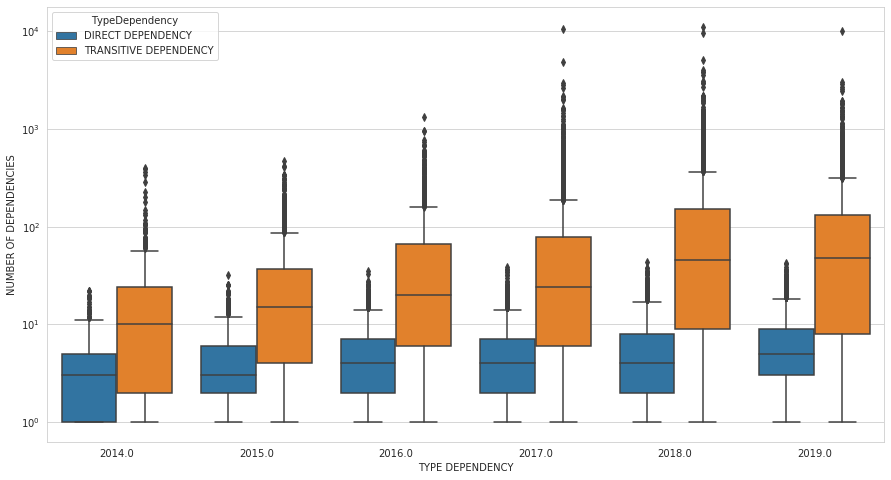

In [81]:
plt.subplots(figsize=(15, 8))
x = sns.boxplot(x='Year/Publication', y='NumberOfDependentPkg', hue="TypeDependency", data=depByPackages)
x.set(yscale="log")
plt.xlabel("TYPE DEPENDENCY")
plt.ylabel("NUMBER OF DEPENDENCIES")

<a id='section3.3.2'></a>
## Evolución del número de dependencias transitivas y dependencias directas

In [82]:
law_II = df_rel.copy()
law_II.shape

(1629860, 8)

In [83]:
groupByYear = law_II.groupby(['Year_Month/Publication','TypeDependency'])[['Imports']].count()
groupByYear = groupByYear.rename(columns={'Imports': 'NumberOfPackage'})
groupByYear.reset_index('TypeDependency',inplace=True)
groupByYear.head()

,TypeDependency,NumberOfPackage
Year_Month/Publication,,
2014-01,DIRECT DEPENDENCY,181
2014-01,TRANSITIVE DEPENDENCY,375
2014-02,DIRECT DEPENDENCY,191
2014-02,TRANSITIVE DEPENDENCY,572
2014-03,DIRECT DEPENDENCY,298


In [84]:
DD = groupByYear[groupByYear['TypeDependency'] == "DIRECT DEPENDENCY"]
TD = groupByYear[groupByYear['TypeDependency'] == "TRANSITIVE DEPENDENCY"]

In [85]:
TD.head()

,TypeDependency,NumberOfPackage
Year_Month/Publication,,
2014-01,TRANSITIVE DEPENDENCY,375
2014-02,TRANSITIVE DEPENDENCY,572
2014-03,TRANSITIVE DEPENDENCY,777
2014-04,TRANSITIVE DEPENDENCY,933
2014-05,TRANSITIVE DEPENDENCY,1365


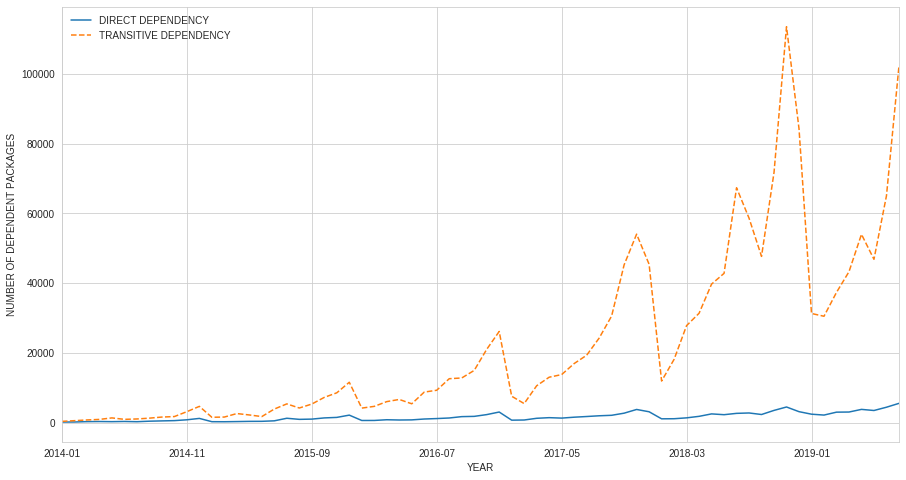

In [86]:
fig, ax = plt.subplots(figsize=(15, 8))
plt.style.use('seaborn-darkgrid')

DD.plot(x_compat=True, ax=ax)
TD.plot(x_compat=True, ax=ax, linestyle='--')

ax.legend(["DIRECT DEPENDENCY", "TRANSITIVE DEPENDENCY"])
plt.xlabel("YEAR")
plt.ylabel("NUMBER OF DEPENDENT PACKAGES")
plt.show()

Por ejemplo, el popular paquete *dplyr* en R tiene 12 dependencias directas (Ver <a href='#section4.4.3'>Paquetes más requeridos</a>), pero depende de forma transitiva de 58 paquetes. Como consecuencia, cada uno de los 1,287 paquetes paquetes que dependen directamente de *dplyr* dependen implícitamente de 70 paquetes adicionales.

In [87]:
pkg_scales = law_II[(law_II['MainPackage'] == "dplyr") & 
                    (law_II['level'] == 0) &
                    (law_II['Year/Publication'] == 2018)]
pkg_scales

,MainPackage,Package,Imports,level,Relationship,Year/Publication,Year_Month/Publication,TypeDependency
559814,dplyr,dplyr,assertthat,0,dplyr|assertthat,2018.0,2018-11,DIRECT DEPENDENCY
559815,dplyr,dplyr,bindrcpp,0,dplyr|bindrcpp,2018.0,2018-11,DIRECT DEPENDENCY
559816,dplyr,dplyr,glue,0,dplyr|glue,2018.0,2018-11,DIRECT DEPENDENCY
559817,dplyr,dplyr,magrittr,0,dplyr|magrittr,2018.0,2018-11,DIRECT DEPENDENCY
559818,dplyr,dplyr,methods,0,dplyr|methods,2018.0,2018-11,DIRECT DEPENDENCY
559819,dplyr,dplyr,pkgconfig,0,dplyr|pkgconfig,2018.0,2018-11,DIRECT DEPENDENCY
559820,dplyr,dplyr,R6,0,dplyr|R6,2018.0,2018-11,DIRECT DEPENDENCY
559821,dplyr,dplyr,Rcpp,0,dplyr|Rcpp,2018.0,2018-11,DIRECT DEPENDENCY
559822,dplyr,dplyr,rlang,0,dplyr|rlang,2018.0,2018-11,DIRECT DEPENDENCY
559823,dplyr,dplyr,tibble,0,dplyr|tibble,2018.0,2018-11,DIRECT DEPENDENCY


In [88]:
pkg_scales_T = law_II[(law_II['MainPackage'] == "dplyr") & 
                    (law_II['TypeDependency'] == "TRANSITIVE DEPENDENCY") &
                    (law_II['Year/Publication'] == 2018)]
pkg_scales_T.shape

(58, 8)

## Paquetes con mayor número de dependencias directas (Año 2018)

In [89]:
df_DirectDep = dfl_law_IV.dropna(subset=['Date/Publication']).copy()
dfl_DirectDep = df_DirectDep[pd.to_numeric(df_DirectDep['Year/Publication']) == 2018]
groupDirectDependency = dfl_DirectDep.groupby('Package')[['NumberOfImports']].sum()
groupDirectDependency = groupDirectDependency.rename(columns={'TypeDependency': 'NumberOfImports'})
groupDirectDependency.sort_values('NumberOfImports', ascending=False, inplace=True)
groupDirectDependency.head(10)

,NumberOfImports
Package,
CNVScope,43
smartR,38
diceR,38
dartR,35
Seurat,35
MetaIntegrator,34
teachingApps,34
metacoder,33
wilson,33


In [90]:
dfl_DirectDep[(dfl_DirectDep['Package'] == 'CNVScope')][['Package','Version','Year/Publication','Imports','NumberOfImports']]

,Package,Version,Year/Publication,Imports,NumberOfImports
30782,CNVScope,1.9.7,2018,"['readr', 'DT', 'InteractionSet', 'BiocManager...",43


Dependencias directas y transitivas

In [91]:
pkg_CNVScope = law_II[(law_II['MainPackage'] == "CNVScope") &
                      (law_II['TypeDependency'] == "DIRECT DEPENDENCY") &
                      (law_II['Year/Publication'] == 2018)]
pkg_CNVScope.shape

(43, 8)

In [92]:
pkg_CNVScope_T = law_II[(law_II['MainPackage'] == "CNVScope") &
                      (law_II['TypeDependency'] == "TRANSITIVE DEPENDENCY") &
                      (law_II['Year/Publication'] == 2018)]
pkg_CNVScope_T.shape

(1528, 8)

In [93]:
# En que profundidad el paquete es requerido
groupCNVScope_T = pkg_CNVScope_T.groupby('level')[['level']].count()
groupCNVScope_T = groupCNVScope_T.rename(columns={'level': 'NumberOfPackage'})
groupCNVScope_T

,NumberOfPackage
level,
1,139
2,293
3,333
4,328
5,233
6,129
7,60
8,13


El paquete pkg_CNVScope_T, por ejemplo es requerido en un primer nivel por 139, es decir es una depedencia de una dependencia

<a id='section3.3.3'></a>
## Proporción de paquetes por profundidad de su árbol de dependencias

In [94]:
# df para el año 2018, con la última versión de cada paquete
df_law_II_2018 = law_II[law_II['Year/Publication'] == 2018]
df_ByLevel = df_law_II_2018.groupby(['level', 'MainPackage'])[['Imports']].count()
df_ByLevel = df_ByLevel.rename(columns={'Imports': 'NumberOfPackage'})
df_ByLevel.reset_index(inplace=True)
df_ByLevel.head()

,level,MainPackage,NumberOfPackage
0,0,ABPS,1
1,0,ACA,4
2,0,ACMEeqtl,1
3,0,ACTCD,3
4,0,ADMM,7


In [95]:
groupByLevel = df_ByLevel.groupby('level')[['NumberOfPackage']].sum()
groupByLevel.reset_index(inplace=True)
groupByLevel = groupByLevel[groupByLevel['level'] != 0] # Elimina dependencias directas
groupByLevel['ProportionOfPackage'] = groupByLevel['NumberOfPackage'] / groupByLevel['NumberOfPackage'].sum() * 100
groupByLevel.head()

,level,NumberOfPackage,ProportionOfPackage
1,1,83521,13.584383
2,2,125836,20.466762
3,3,137851,22.420958
4,4,112271,18.260465
5,5,76323,12.413655


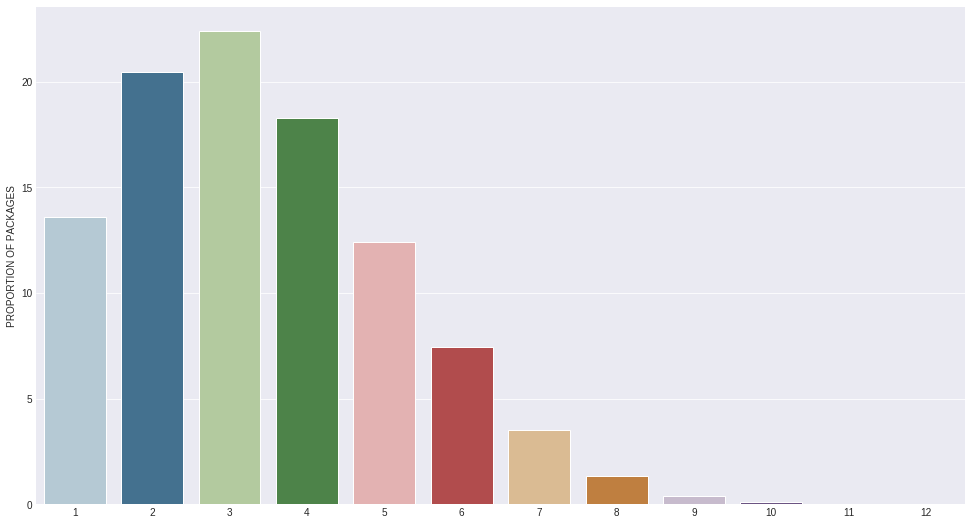

In [96]:
x = sns.catplot(x="level", y="ProportionOfPackage", data=groupByLevel, saturation=.5,
                 kind="bar", ci=None, height=5, aspect=1, palette="Paired")
x.fig.set_size_inches(15,8)

x.set_axis_labels("", "PROPORTION OF PACKAGES")
x.set_titles("{col_name} UPDATES")
x.despine(left=True)

<a id='section3.3.4'></a>
## Paquetes que son requeridos transitivamente por al menos el 3% de todos los paquetes

In [97]:
law_II_T = df_rel[df_rel['level'] != 0].copy()
law_II_T.head()

,MainPackage,Package,Imports,level,Relationship,Year/Publication,Year_Month/Publication,TypeDependency
5461,AICcmodavg,nlme,lattice,1,AICcmodavg|nlme|lattice,2014.0,2014-10,TRANSITIVE DEPENDENCY
5462,BayesLCA,nlme,lattice,1,BayesLCA|nlme|lattice,2014.0,2014-11,TRANSITIVE DEPENDENCY
5463,GSIF,nlme,lattice,1,GSIF|nlme|lattice,2014.0,2014-12,TRANSITIVE DEPENDENCY
5464,GxM,nlme,lattice,1,GxM|nlme|lattice,2014.0,2014-09,TRANSITIVE DEPENDENCY
5465,MARSS,nlme,lattice,1,MARSS|nlme|lattice,2014.0,2014-03,TRANSITIVE DEPENDENCY


In [98]:
T_1 = law_II_T.groupby(['Year/Publication','Imports'])[['Package']].count()
T_1.shape

(3925, 1)

In [99]:
T_2 = law_II_T.groupby(['Year/Publication','Package'])[['MainPackage']].count()
T_2.shape

(4166, 1)

In [100]:
yearByPkg_T = pd.concat([T_1, T_2], axis=1)
yearByPkg_T.head()

Package  MainPackage
2014.0 ADGofTest       5.0          NaN
       AICcmodavg      NaN         10.0
       AUC             2.0          NaN
       AntWeb          NaN          5.0
       BB              5.0         20.0

In [101]:
yearByPkg_T['RequiredPackage'] = yearByPkg_T.sum(axis=1)
yearByPkg_T.drop(['Package','MainPackage'], axis=1, inplace=True)
yearByPkg_T.head()

RequiredPackage
2014.0 ADGofTest               5.0
       AICcmodavg             10.0
       AUC                     2.0
       AntWeb                  5.0
       BB                     25.0

In [102]:
yearByPkg_T['ProportionOfPackage'] = yearByPkg_T.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
yearByPkg_T.head()

RequiredPackage  ProportionOfPackage
2014.0 ADGofTest               5.0             0.013508
       AICcmodavg             10.0             0.027015
       AUC                     2.0             0.005403
       AntWeb                  5.0             0.013508
       BB                     25.0             0.067538

In [103]:
# Paquetes que son requeridos al menos por 3% de todos los paquetes
pkgRequired_T = yearByPkg_T[yearByPkg_T['ProportionOfPackage'] >= 3].copy()
pkgRequired_T.reset_index(inplace=True)
pkgRequired_T = pkgRequired_T.rename(columns={'level_0': 'Year', 'level_1': 'Package'})
pkgRequired_T.sort_values(['Year','ProportionOfPackage'], ascending=[True,True], inplace=True)
pkgRequired_T.head(10)

,Year,Package,RequiredPackage,ProportionOfPackage
8,2014.0,scales,1144.0,3.090555
2,2014.0,grDevices,1150.0,3.106765
7,2014.0,plyr,1414.0,3.819970
4,2014.0,grid,1443.0,3.898314
0,2014.0,Matrix,1520.0,4.106332
9,2014.0,stats,1587.0,4.287335
10,2014.0,utils,1716.0,4.635833
3,2014.0,graphics,1747.0,4.719581
6,2014.0,methods,2202.0,5.948779
1,2014.0,Rcpp,2485.0,6.713313


In [104]:
pkgRequired_T[pkgRequired_T['Year'] == 2018]

,Year,Package,RequiredPackage,ProportionOfPackage
42,2018.0,rlang,41772.0,3.397031
39,2018.0,crayon,47504.0,3.863175
37,2018.0,Rcpp,60526.0,4.922166
43,2018.0,tibble,77459.0,6.299211
41,2018.0,pillar,77895.0,6.334668
44,2018.0,utils,87414.0,7.108783
40,2018.0,methods,95353.0,7.754407
38,2018.0,cli,114195.0,9.286698


Text(0, 0.5, 'NUMBER OF PACKAGES')

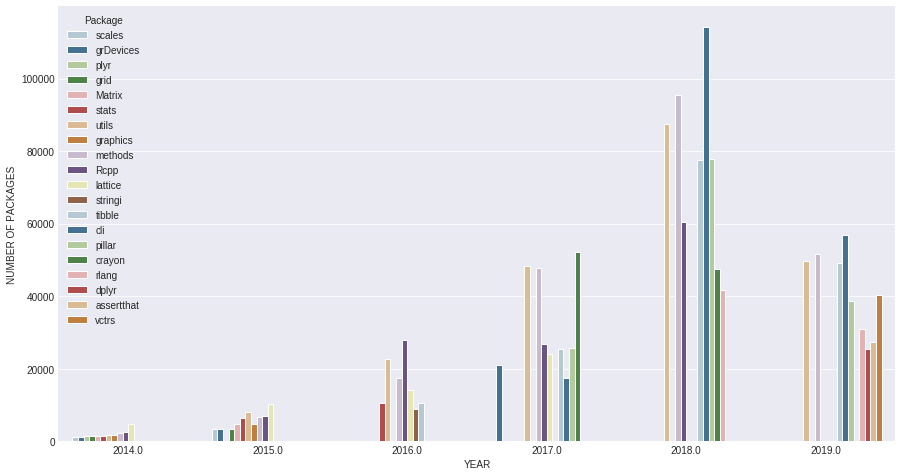

In [105]:
plt.subplots(figsize=(15, 8))
ax = sns.barplot(x='Year', y='RequiredPackage', data=pkgRequired_T, hue='Package', saturation=.5, palette="Paired")
plt.xlabel("YEAR")
plt.ylabel("NUMBER OF PACKAGES")

<a id='section4.0'></a>
# 4.0. Más gráficos

<a id='section4.1'></a>
## Distribución de los cicuenta paquetes R con más versiones

In [106]:
dfl = df.copy()
dfl.shape

(87912, 48)

In [107]:
v_packageByYear = dfl.groupby(['Package', 'Year/Publication'])[['Package']].count()
v_packageByYear = v_packageByYear.rename(columns={'Package': 'NumberOfVersions'})
v_packageByYear.head(15)

NumberOfVersions
Package      Year/Publication                  
A3           2013                             2
             2015                             1
ABC.RAP      2016                             1
ABCanalysis  2015                             4
             2016                             2
             2017                             1
ABCoptim     2013                             2
             2016                             1
             2017                             1
ABCp2        2013                             2
             2016                             1
ABHgenotypeR 2016                             2
ABPS         2017                             1
             2018                             2
ACA          2016                             1

In [108]:
pkg_maxversions = pd.DataFrame()

v_packageByYear = v_packageByYear.reset_index()
max_versions = versions_package[0:50]['Package'].tolist()

for i in max_versions:
    pkg_maxversions = pkg_maxversions.append(v_packageByYear[v_packageByYear['Package'] == i])
    
pkg_maxversions.shape

(497, 3)

Text(0, 0.5, 'NUMBER OF VERSIONS')

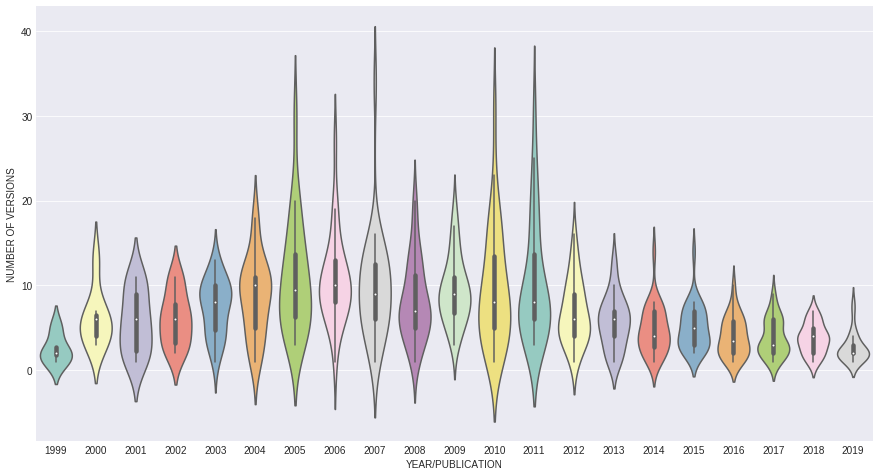

In [109]:
plt.figure(figsize=(15,8))
x = sns.violinplot(x='Year/Publication', y='NumberOfVersions', data=pkg_maxversions, scale='width', palette='Set3')
plt.xlabel('YEAR/PUBLICATION')
plt.ylabel('NUMBER OF VERSIONS')

<a id='section4.2'></a>
## Antiguedad de los paquetes

In [110]:
#df['Year/Publication'] = pd.to_datetime(df['Year/Publication']).dt.year
df_pkg_date = dfl.set_index(['Package', 'Version'])
df_pkg_date = df_pkg_date.sort_values("DatePublication", ascending=True)
df_pkg_date.head(3)

,,Type,Title,Date,Author,Maintainer,Description,License,Depends,Suggests,Packaged,...,Priority,NumberOfImports,NumberOfDepends,NumberOfSuggests,NumberOfLinkingTo,DatePublication,Year/Publication,Month/Publication,Day/Publication,Year_Month/Publication
Package,Version,,,,,,,,,,,,,,,,,,,,,
leaps,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,[],[],NaN,...,NaN,0,0,0,0,1997-12-10,1997,12,10,1997-12
oz,1.0-3,NaN,NaN,NaN,[S original by Bill Venables <Bill.Venables@ad...,NaN,Functions for plotting Australia's coastline a...,GPL,[],[],NaN,...,NaN,0,0,0,0,1998-02-25,1998,2,25,1998-02
mda,0.1-1,NaN,NaN,NaN,[S original by Hastie & Tibshirani.<U+000a>R p...,NaN,"Mixture and flexible discriminat analysis, mul...",???,[],[],NaN,...,NaN,0,0,0,0,1998-04-17,1998,4,17,1998-04


In [111]:
def first_last_package(df):
    return df.iloc[[0, -1]]

package_age = df_pkg_date[['Year/Publication']].groupby(level=0, group_keys=False).apply(first_last_package)
package_age.head()

Year/Publication
Package     Version                  
A3          0.9.1                2013
            1.0.0                2015
ABC.RAP     0.9.0                2016
            0.9.0                2016
ABCanalysis 1.0                  2015

In [112]:
funcs = {
        ('DateFirstPackage', 'min'),
        ('DateLastPackage','max'),
        ('AgeInYears', lambda x: (pd.to_numeric(x.max()) - pd.to_numeric(x.min())))
}
age = package_age.groupby(by='Package')['Year/Publication'].agg(funcs).reset_index()
age.head()

,Package,DateFirstPackage,AgeInYears,DateLastPackage
0,A3,2013,2,2015
1,ABC.RAP,2016,0,2016
2,ABCanalysis,2015,2,2017
3,ABCoptim,2013,4,2017
4,ABCp2,2013,3,2016


In [113]:
age_group = age.groupby('AgeInYears')[['Package']].count().reset_index()
age_group.head(13)

,AgeInYears,Package
0,0,5571
1,1,2395
2,2,1780
3,3,1202
4,4,936
5,5,637
6,6,482
7,7,427
8,8,285
9,9,246


Text(0, 0.5, 'NUMBER OF VERSIONS')

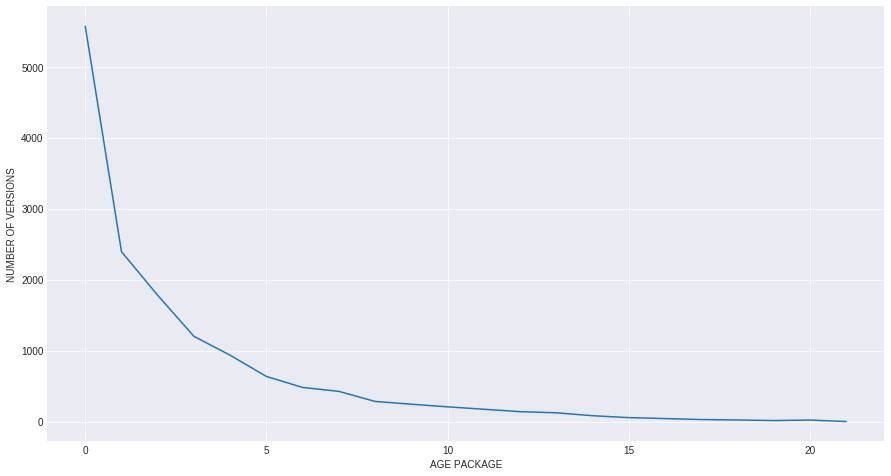

In [114]:
values = age_group['Package']
plt.figure(figsize=(15,8))
plt.plot(values)
plt.xlabel("AGE PACKAGE")
plt.ylabel("NUMBER OF VERSIONS")

<a id='section4.3'></a>

## Número de versiones por paquete

In [115]:
versionByPkg = df.groupby('Package')[['Version']].count()
versionByPkg = versionByPkg.rename(columns={'Version': 'NumberOfVersions'})
versionByPkg.reset_index(inplace=True)
versionByPkg.shape

(14891, 2)

In [116]:
versionByPkg.sort_values('NumberOfVersions', ascending=False).head()

,Package,NumberOfVersions
2426,Matrix,197
13437,spatstat,194
9872,mgcv,151
10497,nlme,135
9227,lattice,133


In [117]:
colnames = versionByPkg.columns.tolist()
versionByPkg.to_csv("DATA_CRAN/VERSIONS_BY_PACKAGE.csv", header=colnames, sep="|", index=False)

In [118]:
versionByPkg[versionByPkg['Package'] == 'arcos']

,Package,NumberOfVersions
5007,arcos,1


In [119]:
df[df['Package'] == 'arcos']

,Package,Type,Title,Version,Date,Author,Maintainer,Description,License,Depends,...,Priority,NumberOfImports,NumberOfDepends,NumberOfSuggests,NumberOfLinkingTo,DatePublication,Year/Publication,Month/Publication,Day/Publication,Year_Month/Publication
2291,arcos,Package,Load ARCOS Prescription Data Prepared by the W...,0.8.2,2019-08-09,"[Steven Rich [aut, ctb],\nAndrew Ba Tran [aut,...",Andrew Ba Tran <andrew.tran@washpost.com>,A wrapper for the 'ARCOS API' <https://arcos-a...,MIT + file LICENSE,['R'],...,NaN,6,1,13,0,2019-08-24,2019,8,24,2019-08


# Conexión con la base de datos obtenida desde la página R-CRAN

Se realizó un *Script Python* que recopila la información de la página de <a href="https://cran.r-project.org/web/packages/available_packages_by_name.html"> R-CRAN</a>. La información que podemos encontrar aquí corresponde a las últimas versiones de los paquetes.

In [120]:
mongo = pymongo.MongoClient("mongodb://localhost:27017/")
database = mongo["PY_CRAN"]
py_collection = database["R_packages"]

In [121]:
df_latest_pkgs = pd.DataFrame(list(py_collection.find()))
df_latest_pkgs.head(3)

,_id,Package,Title,Description,Version,Depends,Imports,Suggests,Published,Author,...,Classification/ACM,Classification/JEL,Enhances,Copyright,Language,Reverse_enhances,Classification/MSC,Reverse_linking_to,OS_type,Priority
0,5d6acae7b847170bab958e75,abbyyR,Access to Abbyy Optical Character Recognition ...,Get text from images of text using Abbyy Cloud...,0.5.5,R (≥ 3.2.0),"[httr, XML, curl, readr, plyr, progress]","[testthat, rmarkdown, knitr (≥ 1.11), lintr]",2019-06-25,"[Gaurav Sood [aut, cre]]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5d6acae7b847170bab958e76,A3,"Accurate, Adaptable, and Accessible Error Metr...",Supplies tools for tabulating and analyzing th...,1.0.0,"[R (≥ 2.15.0), xtable, pbapply]",NaN,"[randomForest, e1071]",2015-08-16,[Scott Fortmann-Roe],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5d6acae7b847170bab958e77,abc,Tools for Approximate Bayesian Computation (ABC),Implements several ABC algorithms forperformin...,2.1,"[R (≥ 2.10), abc.data, nnet, quantreg, MAS...",NaN,NaN,2015-05-05,"[Csillery Katalin [aut], Lemaire Louisiane [au...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [122]:
#Normalizamos las columnas para que sean de tipo lista
df_latest_pkgs['Author'] = df_latest_pkgs[['Author']].applymap(lambda x: [x] if not isinstance(x, list) else x)

df_latest_pkgs['Imports'] = df_latest_pkgs[['Imports']].applymap(lambda x: [x] if not isinstance(x, list) else x)
df_latest_pkgs['Reverse_imports'] = df_latest_pkgs[['Reverse_imports']].applymap(lambda x: [x] if not isinstance(x, list) else x)

df_latest_pkgs['Depends'] = df_latest_pkgs[['Depends']].applymap(lambda x: [x] if not isinstance(x, list) else x)
df_latest_pkgs['Reverse_depends'] = df_latest_pkgs[['Reverse_depends']].applymap(lambda x: [x] if not isinstance(x, list) else x)

df_latest_pkgs['Suggests'] = df_latest_pkgs[['Suggests']].applymap(lambda x: [x] if not isinstance(x, list) else x)
df_latest_pkgs['Reverse_suggests'] = df_latest_pkgs[['Reverse_suggests']].applymap(lambda x: [x] if not isinstance(x, list) else x)

#Remplazamos los valores NaN por una lista vacía
df_latest_pkgs = df_latest_pkgs.applymap(lambda x: [] if str(x) == "[nan]" else x)

In [123]:
df_latest_pkgs['Author'] = df_latest_pkgs[['Author']].applymap(lambda x: [ re.sub(r'\sand\s','',i).strip() for i in x])

In [124]:
df_latest_pkgs.shape

(14890, 41)

<a id='section4.4'></a>
## Paquetes requeridos por otros paquetes (por Depends,  Imports o LinkingTo)

En esta sección analizamos las relaciones de dependencia del ecosistema R para comprender el cambio y la evolución de dependencias entre paquetes. La estructura del proyecto R puede llegar a ser muy complicada, pues cuanto más un paquete es requerido por otros paquetes, los cambios en el paquete central pueden causar defectos que se propagan a los paquetes dependientes

In [125]:
df_adj = df_latest_pkgs[['Package','Imports','Depends','LinkingTo']].copy()

Normalizamos las columnas para que sean de tipo lista

In [126]:
df_adj['Imports'] = df_adj[['Imports']].applymap(lambda x: [x] if not isinstance(x, list) else x)
df_adj['Depends'] = df_adj[['Depends']].applymap(lambda x: [x] if not isinstance(x, list) else x)
df_adj['LinkingTo'] = df_adj[['LinkingTo']].applymap(lambda x: [x] if not isinstance(x, list) else x)

Remplazamos los valores NaN por una lista vacía

In [127]:
df_adj = df_adj.applymap(lambda x: [] if str(x) == "[nan]" else x)
df_adj.head()

,Package,Imports,Depends,LinkingTo
0,abbyyR,"[httr, XML, curl, readr, plyr, progress]",[R (≥ 3.2.0)],[]
1,A3,[],"[R (≥ 2.15.0), xtable, pbapply]",[]
2,abc,[],"[R (≥ 2.10), abc.data, nnet, quantreg, MAS...",[]
3,abc.data,[],[R (≥ 2.10)],[]
4,ABC.RAP,"[graphics, stats, utils]",[R (≥ 3.1.0)],[]


Función para concatenar las listas de cada categoría de dependencia en una única lista con valores únicos.

In [128]:
from collections import OrderedDict

def values_uniques(df):
    return np.unique(list(re.sub(r'\([^()]*\)', '', row).strip() for cols in df for row in cols))

In [129]:
df_adj['all'] = df_adj[['Imports', 'Depends', 'LinkingTo']].apply(values_uniques, axis=1)
df_adj.head()

,Package,Imports,Depends,LinkingTo,all
0,abbyyR,"[httr, XML, curl, readr, plyr, progress]",[R (≥ 3.2.0)],[],"[R, XML, curl, httr, plyr, progress, readr]"
1,A3,[],"[R (≥ 2.15.0), xtable, pbapply]",[],"[R, pbapply, xtable]"
2,abc,[],"[R (≥ 2.10), abc.data, nnet, quantreg, MAS...",[],"[MASS, R, abc.data, locfit, nnet, quantreg]"
3,abc.data,[],[R (≥ 2.10)],[],[R]
4,ABC.RAP,"[graphics, stats, utils]",[R (≥ 3.1.0)],[],"[R, graphics, stats, utils]"


Tranformamos en diccionario la columna *all* y a partir de este creamos una matriz de adyacencia para representar la relación binaria entre cada paquete y sus dependencias (Depends, Imports, LinkingTo)

In [130]:
# Función para crear la matriz de pendencia
def adjacencyMatrix(df, x, y):
    x = dict(zip(df[x], df[y]))
    
    # Relaciones entre paquetes
    edges = [(k, v.strip()) for k, values in x.items() for v in values]
    
    # Obtenemos la matriz de adyacencia
    df_matrix = pd.DataFrame(edges)
    adj_matrix = pd.crosstab(df_matrix[0], df_matrix[1])
    
    # Renombramos el nombre de las columnas
    adj_matrix = adj_matrix.rename_axis(None, axis="columns")
    adj_matrix = adj_matrix.rename_axis(None)
    
    return adj_matrix

# Función para agrupar por rango
def groupByRank(df):
    bins = [0, 1, 10, 100, 1000, 2000, 10000]
    labels = ['0-1','2-10','11-100','101-1000','1001-2000','> 2000']

    df_group = df.sum(axis = 0, skipna = True).to_frame()
    df_group.columns = ['RequiredBy']
    df_group = df_group.sort_values('RequiredBy', ascending=False)
    
    df_group['Group_RequiredBy'] = pd.cut(df_group['RequiredBy'], bins=bins, labels=labels)
    df_group.index.names = ['Package']
    df_group = df_group.reset_index()

    return df_group

Se contruye la matriz de adyacencia de la columna *all* que contiene todas las dependencias de cada paquete, y se usa la función groupByRank() para obtener el número de paquetes requeridos por rango de paquetes

In [131]:
all_matrix = adjacencyMatrix(df_adj,'Package', 'all')
pkgRequiredBy = groupByRank(all_matrix)
GroupRequiredBy = pkgRequiredBy.groupby('Group_RequiredBy').size().reset_index(name='NumberPackages')
GroupRequiredBy.head(6)

,Group_RequiredBy,NumberPackages
0,0-1,1713
1,2-10,1622
2,11-100,470
3,101-1000,89
4,1001-2000,6
5,> 2000,4


Se observa que hay 4 paquetes son requeridos por al menos 2000 paquetes

<a id='section4.4.1'></a>
### Paquetes requeridos por 2000 o más paquetes

In [132]:
pkgRequiredBy[pkgRequiredBy['Group_RequiredBy'] == '> 2000'][['Package','RequiredBy']]

,Package,RequiredBy
0,R,9274
1,stats,3809
2,methods,2778
3,utils,2341


<a id='section4.4.2'></a>
## Paquetes requeridos por más de 1000 y menos de 2000 paquetes

In [133]:
pkgRequiredBy[pkgRequiredBy['Group_RequiredBy'] == '1001-2000'][['Package','RequiredBy']]

,Package,RequiredBy
4,graphics,1906
5,Rcpp,1778
6,ggplot2,1757
7,MASS,1425
8,dplyr,1352
9,grDevices,1172


<a id='section4.4.3'></a>
## TOP 30 - Paquetes más requeridos por el mayor número de otros paquetes

In [134]:
df_RequiredBy = pkgRequiredBy.copy()
#df_RequiredBy = df_RequiredBy.drop(['R', 'stats', 'methods', 'utils', 'graphics', 'grDevices', 'parallel', 'grid'])

Top_30 = df_RequiredBy.merge(df_latest_pkgs, on='Package').head(30)
Top_30[['Package','RequiredBy','Author']]

,Package,RequiredBy,Author
0,Rcpp,1778,"[Dirk Eddelbuettel, Romain Francois, JJ Allair..."
1,ggplot2,1757,"[Hadley Wickham [aut, cre], Winston Chang [aut..."
2,MASS,1425,"[Brian Ripley [aut, cre, cph], Bill Venables [..."
3,dplyr,1352,"[Hadley Wickham[aut, cre], Romain François[aut..."
4,magrittr,863,[Stefan Milton Bache andHadley Wickham]
5,Matrix,851,"[Douglas Bates [aut], Martin Maechler[aut, cre..."
6,stringr,783,"[Hadley Wickham [aut, cre, cph], RStudio [cph,..."
7,jsonlite,696,"[Jeroen Ooms, Duncan Temple Lang, Lloyd Hilaiel]"
8,plyr,658,"[Hadley Wickham [aut, cre]]"
9,RcppArmadillo,656,"[Dirk Eddelbuettel, Romain Francois, Doug Bate..."


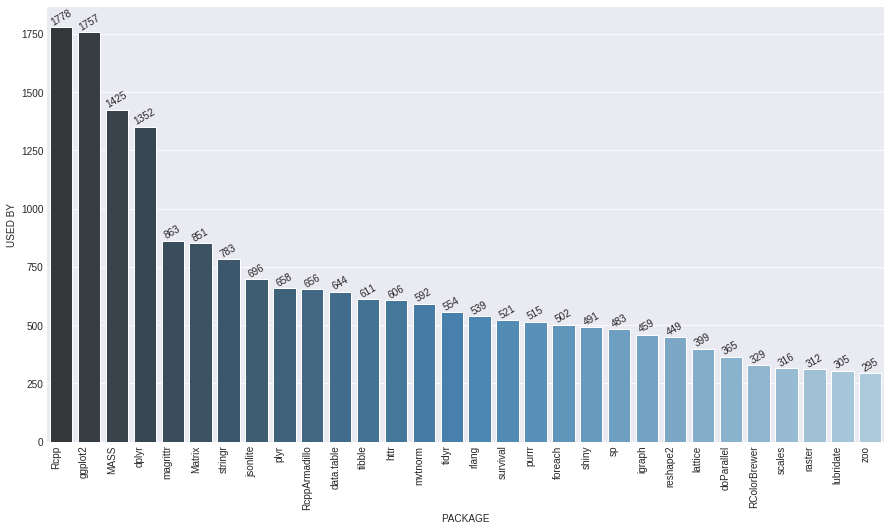

In [135]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x="Package", y="RequiredBy", data=Top_30, palette="Blues_d")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")

for i, v in enumerate(Top_30["RequiredBy"].values):        
    plt.text(i, v, v, horizontalalignment='center', verticalalignment='bottom', rotation=30)

plt.ylabel("USED BY")
plt.xlabel("PACKAGE")
plt.show()

<a id='section4.4.4'></a>
## TOP 20 - Paquetes más relevantes según la categoría de dependencia

Con la siguiente gráfica prentendemos responder a las siguientes preguntas: ¿Qué paquetes son los más importados? ¿Qué paquetes son de los más dependen otros paquetes?

In [136]:
adjImports = adjacencyMatrix(df_adj, 'Package', 'Imports')
adjDepends = adjacencyMatrix(df_adj, 'Package', 'Depends')
adjLinkingTo = adjacencyMatrix(df_adj, 'Package', 'LinkingTo')

df_Imports = groupByRank(adjImports).head(20)
df_Depends = groupByRank(adjDepends).head(20)
df_LinkingTo = groupByRank(adjLinkingTo).head(20)

Text(0, 0.5, 'PACKAGE')

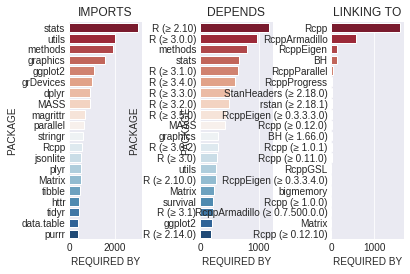

In [137]:
fig = plt.figure()
plt.rcParams['figure.figsize'] = [20,12]
plt.subplots_adjust(wspace=0.8)

ax1 = fig.add_subplot(131)
ax1.set_title("IMPORTS")
sns.barplot(x="RequiredBy", y="Package", data=df_Imports, palette="RdBu",ax=ax1)
ax1.set_xlabel('REQUIRED BY')
ax1.set_ylabel("PACKAGE")

ax2 = fig.add_subplot(132)
ax2.set_title("DEPENDS")
sns.barplot(x="RequiredBy", y="Package", data=df_Depends, palette="RdBu",ax=ax2)
ax2.set_xlabel('REQUIRED BY')
ax2.set_ylabel("PACKAGE")

ax3 = fig.add_subplot(133)
ax3.set_title("LINKING TO")
sns.barplot(x="RequiredBy", y="Package", data=df_LinkingTo, palette="RdBu",ax=ax3)
ax3.set_xlabel('REQUIRED BY')
ax3.set_ylabel("PACKAGE")

<a id='section4.5'></a>
## Número de autores por paquete

In [138]:
def split_dataframe_list(df, column):
    ''' 
    Acepta una columna y divide las variables de la lista en varias filas.
    df: dataframe para dividir
    column: la columna que contiene los valores a dividir
    '''
    
    row_accumulator = []
    
    def split_list_to_rows(row):
        split_row = row[column]
        if isinstance(split_row, list):
            for s in split_row:
                new_row = row.to_dict()
                new_row[column] = s
                row_accumulator.append(new_row)
            if split_row == []:
                new_row = row.to_dict()
                new_row[column] = None
                row_accumulator.append(new_row)
        else:
            new_row = row.to_dict()
            new_row[column] = split_row
            row_accumulator.append(new_row)
            
    df.apply(split_list_to_rows, axis=1)
    new_df = pd.DataFrame(row_accumulator)
    
    return new_df

In [139]:
df_authors = split_dataframe_list(df_latest_pkgs[['Package','Author']], 'Author')
df_authors.shape

(35496, 2)

In [140]:
df_authors.head()

,Package,Author
0,abbyyR,"Gaurav Sood [aut, cre]"
1,A3,Scott Fortmann-Roe
2,abc,Csillery Katalin [aut]
3,abc,Lemaire Louisiane [aut]
4,abc,Francois Olivier [aut]


In [141]:
regex_1 = r'(\[\w+(?:\,[\s|\w]+)*])' # Extrae la cadena dentro de los caracteres []
regex_2 = r'\([^)]*\)' # Regex para buscar en el nombre cadenas dentro de ()

df_authors['IsAuthor'] = df_authors['Author'].str.extract(regex_1, expand=True)
df_authors['Author'] = df_authors['Author'].str.replace(regex_1, '')
df_authors['Author'] = df_authors['Author'].str.replace(regex_2, '')
df_authors['Author'] = df_authors['Author'].str.strip()

In [142]:
df_authors.head()

,Package,Author,IsAuthor
0,abbyyR,Gaurav Sood,"[aut, cre]"
1,A3,Scott Fortmann-Roe,NaN
2,abc,Csillery Katalin,[aut]
3,abc,Lemaire Louisiane,[aut]
4,abc,Francois Olivier,[aut]


In [143]:
groupAuthors = df_authors.groupby('Package')[['Author']].count()
groupAuthors = groupAuthors.rename(columns={'Author': 'NumberOfAuthors'})
groupAuthors.sort_values('NumberOfAuthors', ascending=False, inplace=True)
groupAuthors.reset_index(inplace=True)
groupAuthors = groupAuthors.head(15)
groupAuthors

,Package,NumberOfAuthors
0,spatstat,200
1,rcorpora,115
2,DescTools,105
3,knitr,94
4,fortunes,61
5,bookdown,46
6,rmarkdown,43
7,OpenMx,41
8,rmumps,38
9,data.table,37


In [144]:
x_Package = groupAuthors['Package'].tolist()
y_NumberOfAuthors = groupAuthors['NumberOfAuthors'].tolist()

c = (
    Line()
    .add_xaxis(x_Package)
    .add_yaxis("NUMBER OF AUTHORS", y_NumberOfAuthors,
               label_opts=opts.LabelOpts(is_show=False))
    .extend_axis(
        yaxis=opts.AxisOpts(
            name="NUMBER OF AUTHORS",
            position="left",
            name_location="center",
            name_rotate=90,
            name_gap=50
        ),
        xaxis=opts.AxisOpts(
            name="PACKAGE",
            position="bottom",
            name_location="center",
            name_gap=30
        )
    )
)
c.render_notebook()

<a id='section4.6'></a>
## Número de autores en el ecosistema

In [145]:
len(df_authors['Author'].unique()) # Autores únicos

21294